# Packages

In [1]:
#basic packages
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os

#data pre-processing packages
from datetime import datetime


#results and analysis packages
from sklearn.metrics import mean_absolute_percentage_error as mape
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split


import shap

In [2]:
#linear models packages
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.linear_model import RidgeCV, LassoCV, ElasticNetCV

# from yellowbrick.regressor import PredictionError, ResidualsPlot

#PCA
from sklearn import model_selection
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import PLSRegression, PLSSVD
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import RepeatedKFold

# Script

## Errors computation

In [3]:
#defining the Root Mean Squared Error

def rmse(y_true, y_predicted):
    
    return np.sqrt(mean_squared_error(y_true, y_predicted))

In [4]:
#errors computation

def errors_computation(data):
    
    df=pd.DataFrame()
    df.at['RMSE (as root mean)', 'Wind']= round(rmse(data['Target'], data['WS_pred']), 3)
    df.at['MAE (in avg)', 'Wind']= round(mae(data['Target'], data['WS_pred']), 3)
    df.at['MAPE (%)', 'Wind']= round(mape(data['Target'], data['WS_pred'])*100, 3)
    
    df.at['RMSE (as root mean)', 'Power']= round(rmse(data['P'], data['P_pred']), 3)
    df.at['MAE (in avg)', 'Power']= round(mae(data['P'], data['P_pred']), 3)
    df.at['MAPE (%)', 'Power']= round(mape(data['P'], data['P_pred'])*100, 3)
    
    
    print('Wind RMSE: ', round(rmse(data['Target'], data['WS_pred']), 3), 'm/s as root mean')
    print('Wind MAE: ', round(mae(data['Target'], data['WS_pred']), 3), 'm/s in avg')
    print('Wind MAPE: ', round(mape(data['Target'], data['WS_pred'])*100, 3), '%')
    
    print('Power RMSE: ', round(rmse(data['P'], data['P_pred']), 3), 'kW as root mean')
    print('Power MAE: ', round(mae(data['P'], data['P_pred']), 3), 'kW in avg')
    print('Power MAPE: ', round(mape(data['P'], data['P_pred'])*100, 3), '%')
    
    return df

In [5]:
def error_plot(data, title):
    
    #title is expected to be an str
    #WS_pred and Target should be the variables names

    #plotting the reference
    plt.figure(figsize=(12,8))
    plt.plot([-1,17.5],[-1,17.5], 'green', linewidth=4, alpha=.12)
    plt.plot(data['WS_pred'], data['Target'], marker='o', ls='', label='Regression', markersize=5, alpha=.1)


    plt.legend()

    ax=plt.gca()
    ax.set(xlabel='y predicted', ylabel='y actual');
    ax.set_title(title)
    ax.set_ylim(ymin=4, ymax=17.5)
    ax.set_xlim(xmin=4, xmax=17.5)
    
    return print('')

In [6]:
def powercurve_computation(data, power_curve):
    
    from scipy import interpolate
    
    #this function computes the power at a observation given the information at a observation:
    # the WS (in m/s) at the wind turbine location and at the hub height (Target)
    # the power curve of the wind turbine in an xslx
    
    
    x=power_curve['Wind Speed [m/s]']
    y=power_curve['Warranted Power Curve [kW]']
    x_new=data['Target']
    
    f = interpolate.interp1d(x, y)
    #, kind='linear'
    data['P']=f(x_new)
    
    if 'WS_pred' in data.keys():
        x_new2=data['WS_pred']
        data['P_pred']=f(x_new2)
    
    print('power curve computation performed')
    
    return data

In [7]:
def control_power_computation (data_test, data_train, power_curve):
    
    results_test=pd.DataFrame()
    results_train=pd.DataFrame()
    
    
    results_test=powercurve_computation(data_test, power_curve)
    results_train=powercurve_computation(data_train, power_curve)

    return results_test, results_train

In [8]:
def compute_results(data_test, data_train, power_curve, plot):
    
    #this function computes and plots the results of a modelling:

    results_test, results_train=control_power_computation (data_test, data_train, power_curve)
    
    
    print('Modelling errors for training set:')
    errors_computation(results_train)
    print('')
    print('Modelling errors for test set:')
    errors_computation(results_test)
    
    if plot:
        print('')
        error_plot(results_test, 'Error plot for test set wind speed')

    print('')
    return print('Showing the results of the modelling: ')

## Data uploading

In [9]:
def uploading_csv(file_folder,file_name):
    
    #file folder required
    #file name required
    #file is expected to be in the data root: r'C:\Users\irgaa\Irma\Data'
    #this function uploads and formats csv/txt/xlsx datasets into DataFrame
    
    
    data_root=r'C:\Users\irgaa\Irma\Data'
    data_folder=str(file_folder)
    data_file=str(file_name)
    
    data_path=data_root+data_folder+data_file
    
    data1 = pd.read_csv(data_path)

    
    # We will save the WD_bin as the index
    
    return data1

In [10]:
#this function saves a data csv

def save (data, file_folder,file_name):
    
    #file folder required
    #file name required
    #file is expected to be saved in the data root: r'C:\Users\irgaa\Irma\Data'
    #this function saves a csv/txt/xlsx into Irma's folder
    #the saved file will keep the columns names but not the index
    
    data_root=r'C:\Users\irgaa\Irma\Data'
    data_folder=str(file_folder)
    data_file=str(file_name)
    
    data_path=data_root+data_folder+data_file
    
    data.to_csv (data_path, index = False, header=True)
    
    
    return print('file', data_file, 'saved in', data_folder, 'folder')

## Data selection

In [11]:
def data_selection(X_train, X_test, inputs):
    
    #this function returns the columns of the training and test sets in the inputs list
    
    X_train1 = pd.DataFrame()
    X_test1 = pd.DataFrame()
    
    
    X_train1 = X_train[inputs]
    X_test1 = X_test[inputs]

    
    return X_train1,X_test1
    

In [12]:
def data_drop(X_train, X_test, list_2drop):
    
    #this function returns the columns of the training and test sets in the inputs list

    X_train1 = X_train.drop(columns=list_2drop)
    X_test1 = X_test.drop(columns=list_2drop)

    
    
    return X_train1,X_test1

## Modelling

### Linear regression

In [13]:
def linear_regression(X_train, X_test, y_train, y_test, power_curve, plot):


    linr=LinearRegression()
    linr=linr.fit(X_train, y_train)

    y_pred_test=linr.predict(X_test)
    y_pred_train=linr.predict(X_train)
    
    test=pd.DataFrame(y_pred_test, columns = ['test'])
    train=pd.DataFrame(y_pred_train, columns = ['train'])


    data_test = pd.DataFrame()
    data_train = pd.DataFrame()
    
    data_test['WS_pred']=test['test']
    data_test['Target']=y_test['Target']
    data_train['WS_pred']=train['train']
    data_train['Target']=y_train['Target']
    

    coefs=pd.DataFrame(linr.coef_.T, index=list(X_train.keys()), columns = ['Lin_reg coeffs'])
    
    coefs = coefs.sort_values(['Lin_reg coeffs'], ascending=True)
    
    coefs = coefs[(coefs.T != 0).any()]
        
    coefs.plot(kind='barh', figsize=(9, len(coefs)*0.27))
    plt.title('Linear model Coefficients')
    plt.axvline(x=0, color='.5')
    plt.subplots_adjust(left=.3)
    
    
    compute_results(data_test, data_train, power_curve, plot)
    print('Linear regression & results performed')

    WS_pred=data_test['WS_pred']
    
    return linr,WS_pred

### Polynomial regression

In [14]:
def polynomial_regression(degree, model, cv, alphas, l1_ratios, X_train, X_test, y_train, y_test, power_curve, plot):
    
    
    X_poly = PolynomialFeatures_labeled(X_train,degree)
    X_poly_test = PolynomialFeatures_labeled(X_test,degree)
    
    if model=='linear':
        model_regression, WS_pred=linear_regression(X_poly, X_poly_test, y_train, y_test, power_curve, plot)
    elif model=='ridge':
        model_regression, WS_pred=ridgecv_regression(X_poly, X_poly_test, y_train, y_test, cv, alphas, power_curve, plot)
    elif model=='lasso':
        model_regression, WS_pred=lassocv_regression(X_poly, X_poly_test, y_train, y_test, cv, alphas, power_curve, plot)
    elif model=='elasticnet':
        model_regression, WS_pred=elasticnetcv_regression(X_poly, X_poly_test, y_train, y_test, cv, alphas, l1_ratios, power_curve, plot)
    print('')
    
    print('Polynomial regression & results performed')
    
    return model_regression, WS_pred

In [15]:
def PolynomialFeatures_labeled(input_df,power):
    '''Basically this is a cover for the sklearn preprocessing function. 
    The problem with that function is if you give it a labeled dataframe, it ouputs an unlabeled dataframe with potentially
    a whole bunch of unlabeled columns. 

    Inputs:
    input_df = Your labeled pandas dataframe (list of x's not raised to any power) 
    power = what order polynomial you want variables up to. (use the same power as you want entered into pp.PolynomialFeatures(power) directly)

    Ouput:
    Output: This function relies on the powers_ matrix which is one of the preprocessing function's outputs to create logical labels and 
    outputs a labeled pandas dataframe   
    '''
    poly = PolynomialFeatures(power)
    output_nparray = poly.fit_transform(input_df)
    powers_nparray = poly.powers_

    input_feature_names = list(input_df.columns)
    target_feature_names = ["Constant Term"]
    for feature_distillation in powers_nparray[1:]:
        intermediary_label = ""
        final_label = ""
        for i in range(len(input_feature_names)):
            if feature_distillation[i] == 0:
                continue
            else:
                variable = input_feature_names[i]
                power = feature_distillation[i]
                intermediary_label = "%s^%d" % (variable,power)
                if final_label == "":         #If the final label isn't yet specified
                    final_label = intermediary_label
                else:
                    final_label = final_label + " x " + intermediary_label
        target_feature_names.append(final_label)
    output_df = pd.DataFrame(output_nparray, columns = target_feature_names)
    return output_df

### Ridge regression

In [16]:
def ridgecv_regression(X_train, X_test, y_train, y_test, cv, alphas, power_curve, plot):
    

    ridgeCV=RidgeCV(alphas=alphas,
                   cv=cv).fit(X_train, y_train.values.ravel())

    y_pred_test=ridgeCV.predict(X_test)
    y_pred_train=ridgeCV.predict(X_train)
    
    
    test=pd.DataFrame(y_pred_test, columns = ['test'])
    train=pd.DataFrame(y_pred_train, columns = ['train'])


    data_test = pd.DataFrame()
    data_train = pd.DataFrame()
    
    data_test['WS_pred']=test['test']
    data_test['Target']=y_test['Target']
    data_train['WS_pred']=train['train']
    data_train['Target']=y_train['Target']
    
    print('Best alpha: ', ridgeCV.alpha_)
    print('')
    
    
    coefs=pd.DataFrame(ridgeCV.coef_.T, index=list(X_train.keys()), columns = ['RidgeCV_reg coeffs'])
    
    print('Of {} coefficients, {} are non-zero with RidgeCV.'. format(len(coefs),int(coefs.astype(bool).sum(axis=0).values)))
    
    coefs = coefs.sort_values(['RidgeCV_reg coeffs'], ascending=True)
    
    coefs = coefs[(coefs.T != 0).any()]
    
    
    coefs.plot(kind='barh', figsize=(9, len(coefs)*0.27))
    plt.title('Linear model Coefficients')
    plt.axvline(x=0, color='.5')
    plt.subplots_adjust(left=.3)
    
    
    
    print('')
    compute_results(data_test, data_train, power_curve, plot)
    print('')
    print('RidgeCV regression & results performed')
    
    WS_pred=data_test['WS_pred']
    
    return ridgeCV,WS_pred


### Lasso regression

In [17]:
def lassocv_regression(X_train, X_test, y_train, y_test, cv, alphas, power_curve, plot):
    

    
    lassoCV=LassoCV(alphas=alphas,
                   cv=cv).fit(X_train, y_train.values.ravel())

    y_pred_test=lassoCV.predict(X_test)
    y_pred_train=lassoCV.predict(X_train)
    
    
    test=pd.DataFrame(y_pred_test, columns = ['test'])
    train=pd.DataFrame(y_pred_train, columns = ['train'])


    data_test = pd.DataFrame()
    data_train = pd.DataFrame()
    
    data_test['WS_pred']=test['test']
    data_test['Target']=y_test['Target']
    data_train['WS_pred']=train['train']
    data_train['Target']=y_train['Target']
    
    print('Best alpha: ', lassoCV.alpha_)
    print('')
    
    
    coefs=pd.DataFrame(lassoCV.coef_.T, index=list(X_train.keys()), columns = ['LassoCV_reg coeffs'])
    
    print('Of {} coefficients, {} are non-zero with LassoCV.'. format(len(coefs),int(coefs.astype(bool).sum(axis=0).values)))
    
    coefs = coefs.sort_values(['LassoCV_reg coeffs'], ascending=True)
    
    coefs = coefs[(coefs.T != 0).any()]
    
    coefs.plot(kind='barh', figsize=(9, len(coefs)*0.27))
    plt.title('Linear model Coefficients')
    plt.axvline(x=0, color='.5')
    plt.subplots_adjust(left=.3)
    
    print('')
    compute_results(data_test, data_train, power_curve, plot)
    print('')
    print('LassoCV regression & results performed')
    

    WS_pred=data_test['WS_pred']
    
    return lassoCV,WS_pred

### ElasticNet regression

In [18]:
def elasticnetcv_regression(X_train, X_test, y_train, y_test, cv, alphas, l1_ratios, power_curve, plot):
    
#     The first machine learning model taken into consideration is the polynomial with
#     regularization. The regularization technique chosen is known as "Elastic Net" which
#     is a middle point between Ridge Regression and Lasso Regression.
#     When r=0--> Ridge
#     When r=1--> Lasso

    elasticNetCV= ElasticNetCV(alphas=alphas, l1_ratio=l1_ratios, cv=cv,
                               max_iter=1e4).fit(X_train, y_train.values.ravel())

    y_pred_test=elasticNetCV.predict(X_test)
    y_pred_train=elasticNetCV.predict(X_train)
    
    test=pd.DataFrame(y_pred_test, columns = ['test'])
    train=pd.DataFrame(y_pred_train, columns = ['train'])


    data_test = pd.DataFrame()
    data_train = pd.DataFrame()
    
    data_test['WS_pred']=test['test']
    data_test['Target']=y_test['Target']
    data_train['WS_pred']=train['train']
    data_train['Target']=y_train['Target']
    
    print('Best alpha: ', elasticNetCV.alpha_)
    print('')
    print('Best l1_ratio: ' , elasticNetCV.l1_ratio_)
    
    
    coefs=pd.DataFrame(elasticNetCV.coef_.T, index=list(X_train.keys()), columns = ['ElasticNetCV_reg coeffs'])
    
    print('Of {} coefficients, {} are non-zero with ElasticNetCV.'. format(len(coefs),int(coefs.astype(bool).sum(axis=0).values)))
    
    
    coefs = coefs.sort_values(['ElasticNetCV_reg coeffs'], ascending=True)
    
    coefs = coefs[(coefs.T != 0).any()]
    
    coefs.plot(kind='barh', figsize=(9, len(coefs)*0.27))
    plt.title('Linear model Coefficients')
    plt.axvline(x=0, color='.5')
    plt.subplots_adjust(left=.3)
    
    print('')
    compute_results(data_test, data_train, power_curve, plot)
    print('')
    print('ElasticNetCV regression & results performed')

    WS_pred=data_test['WS_pred']
    
    return elasticNetCV,WS_pred

## Feature importance

In [19]:
def feature_importance (X_train, X_test, model):
    

    X100=shap.utils.sample(X_test, 100)
    
    explainer = shap.Explainer(model.predict, X100)
    shap_values = explainer(X_test)
    shap.summary_plot(shap_values, X_train, plot_type="bar")
    shap.plots.beeswarm(shap_values)
    
    
    print('Feature importance through SHAP values performed')
    
    return shap_values

In [20]:
def transform_shap (shap_values, X_test):

    v=np.array(shap_values.values)
    d=v.reshape(X_test.shape)
    shap_v=pd.DataFrame(d)
    
    feature_list=X_test.columns
    shap_v.columns=feature_list
    shap_v=shap_v.abs()
    k=pd.DataFrame(shap_v.mean()).reset_index()
    k.columns=['variables','SHAP_abs']
    k.sort_values(by='variables')
    
    return k

# Data analysis

## Dataset1- WTG14

In [21]:
#upload the dataset with file_folder, file_name
# data_up= uploading_csv('\Dataset1-Normal_Site','\data_comp14.csv')
X_train= uploading_csv('\Dataset1-Normal_Site','\X_train14.csv')
X_test= uploading_csv('\Dataset1-Normal_Site','\X_test14.csv')
y_train= uploading_csv('\Dataset1-Normal_Site','\y_train14.csv')
y_test= uploading_csv('\Dataset1-Normal_Site','\y_test14.csv')

X_test.keys()

Index(['T2', 'RH2', 'T1', 'RH1', 'PR1', 'AD1', 'PR2', 'AD2', 'Rain', 'WS1',
       'WS3', 'WS4', 'WD1', 'WD3', 'WD4', 'WSHor', 'WDHor', 'WSVer', 'WDVer',
       'TI', 'WSH', 'WD_bin', 'tod', 'WVeer'],
      dtype='object')

In [22]:
y_test.keys()

Index(['Target'], dtype='object')

In [23]:
PC= uploading_csv('\Dataset1-Normal_Site','\PC_1.15kgm-3.csv')

### Linear regression

power curve computation performed
power curve computation performed
Modelling errors for training set:
Wind RMSE:  0.42 m/s as root mean
Wind MAE:  0.316 m/s in avg
Wind MAPE:  3.698 %
Power RMSE:  186.782 kW as root mean
Power MAE:  115.921 kW in avg
Power MAPE:  8.314 %

Modelling errors for test set:
Wind RMSE:  0.434 m/s as root mean
Wind MAE:  0.327 m/s in avg
Wind MAPE:  3.824 %
Power RMSE:  196.68 kW as root mean
Power MAE:  124.899 kW in avg
Power MAPE:  8.636 %

Showing the results of the modelling: 
Linear regression & results performed


LinearRegression()

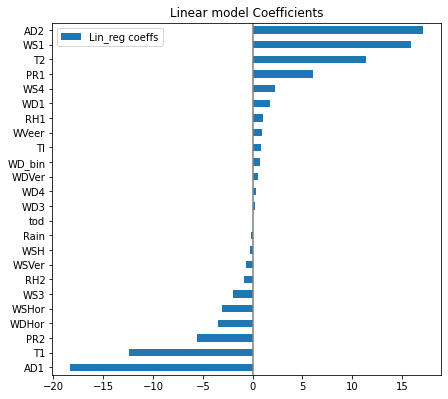

In [24]:
#results with all the variables

linear_regression(X_train, X_test, y_train, y_test, PC, plot=False)

power curve computation performed
power curve computation performed
Modelling errors for training set:
Wind RMSE:  0.424 m/s as root mean
Wind MAE:  0.319 m/s in avg
Wind MAPE:  3.724 %
Power RMSE:  187.883 kW as root mean
Power MAE:  116.793 kW in avg
Power MAPE:  8.34 %

Modelling errors for test set:
Wind RMSE:  0.44 m/s as root mean
Wind MAE:  0.333 m/s in avg
Wind MAPE:  3.898 %
Power RMSE:  198.83 kW as root mean
Power MAE:  126.496 kW in avg
Power MAPE:  8.785 %

Showing the results of the modelling: 
Linear regression & results performed


LinearRegression()

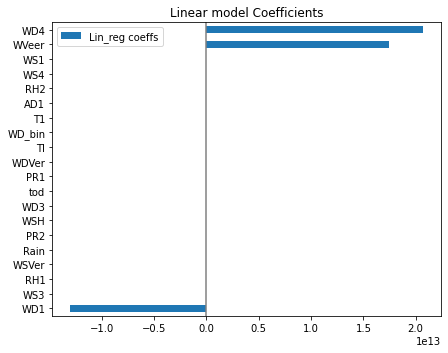

In [25]:
#dropping the following variables:
list_2drop=['T2', 'AD2', 'WDHor', 'WSHor']
X_train1, X_test1 =data_drop(X_train, X_test, list_2drop)
linear_regression(X_train1, X_test1, y_train, y_test, PC, plot=False)

power curve computation performed
power curve computation performed
Modelling errors for training set:
Wind RMSE:  0.441 m/s as root mean
Wind MAE:  0.33 m/s in avg
Wind MAPE:  3.853 %
Power RMSE:  195.072 kW as root mean
Power MAE:  120.393 kW in avg
Power MAPE:  8.636 %

Modelling errors for test set:
Wind RMSE:  0.45 m/s as root mean
Wind MAE:  0.335 m/s in avg
Wind MAPE:  3.947 %
Power RMSE:  205.396 kW as root mean
Power MAE:  128.897 kW in avg
Power MAPE:  9.008 %

Showing the results of the modelling: 
Linear regression & results performed


LinearRegression()

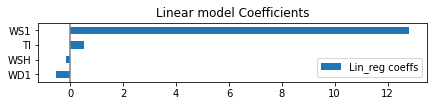

In [26]:
#SELECTING the following variables:
inputs=['WS1','WD1', 'WSH', 'TI']
X_train1, X_test1 =data_selection(X_train, X_test, inputs)
linear_regression(X_train1, X_test1, y_train, y_test, PC, plot=False)

### Polynomial Linear regression

power curve computation performed
power curve computation performed
Modelling errors for training set:
Wind RMSE:  0.429 m/s as root mean
Wind MAE:  0.319 m/s in avg
Wind MAPE:  3.739 %
Power RMSE:  189.456 kW as root mean
Power MAE:  115.772 kW in avg
Power MAPE:  8.404 %

Modelling errors for test set:
Wind RMSE:  0.435 m/s as root mean
Wind MAE:  0.323 m/s in avg
Wind MAPE:  3.824 %
Power RMSE:  197.525 kW as root mean
Power MAE:  123.499 kW in avg
Power MAPE:  8.822 %

Showing the results of the modelling: 
Linear regression & results performed

Polynomial regression & results performed


LinearRegression()

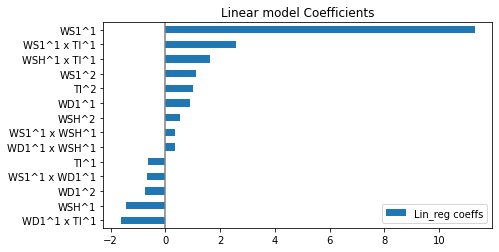

In [27]:
inputs=['WS1','WD1', 'WSH', 'TI']
X_train1, X_test1 =data_selection(X_train, X_test, inputs)
degree=2
cv=None
alphas=None
model='linear'
l1_ratios=None
polynomial_regression(degree, model, cv, alphas, l1_ratios, X_train1, X_test1, y_train, y_test, PC, plot=False)

power curve computation performed
power curve computation performed
Modelling errors for training set:
Wind RMSE:  0.313 m/s as root mean
Wind MAE:  0.238 m/s in avg
Wind MAPE:  2.785 %
Power RMSE:  141.896 kW as root mean
Power MAE:  88.451 kW in avg
Power MAPE:  6.179 %

Modelling errors for test set:
Wind RMSE:  0.387 m/s as root mean
Wind MAE:  0.284 m/s in avg
Wind MAPE:  3.366 %
Power RMSE:  178.756 kW as root mean
Power MAE:  107.551 kW in avg
Power MAPE:  7.678 %

Showing the results of the modelling: 
Linear regression & results performed

Polynomial regression & results performed


LinearRegression()

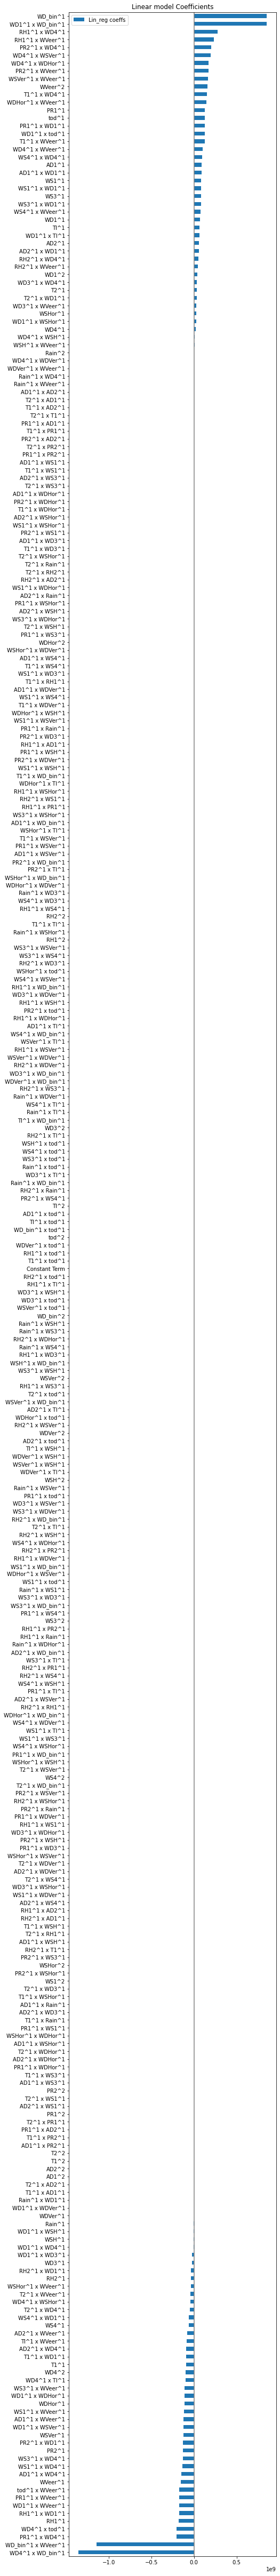

In [28]:
degree=2
cv=None
alphas=None
model='linear'
l1_ratios=None
polynomial_regression(degree, model, cv, alphas, l1_ratios, X_train, X_test, y_train, y_test, PC, plot=False)

power curve computation performed
power curve computation performed
Modelling errors for training set:
Wind RMSE:  0.327 m/s as root mean
Wind MAE:  0.247 m/s in avg
Wind MAPE:  2.88 %
Power RMSE:  145.856 kW as root mean
Power MAE:  90.653 kW in avg
Power MAPE:  6.332 %

Modelling errors for test set:
Wind RMSE:  0.373 m/s as root mean
Wind MAE:  0.283 m/s in avg
Wind MAPE:  3.347 %
Power RMSE:  166.478 kW as root mean
Power MAE:  105.932 kW in avg
Power MAPE:  7.675 %

Showing the results of the modelling: 
Linear regression & results performed

Polynomial regression & results performed


LinearRegression()

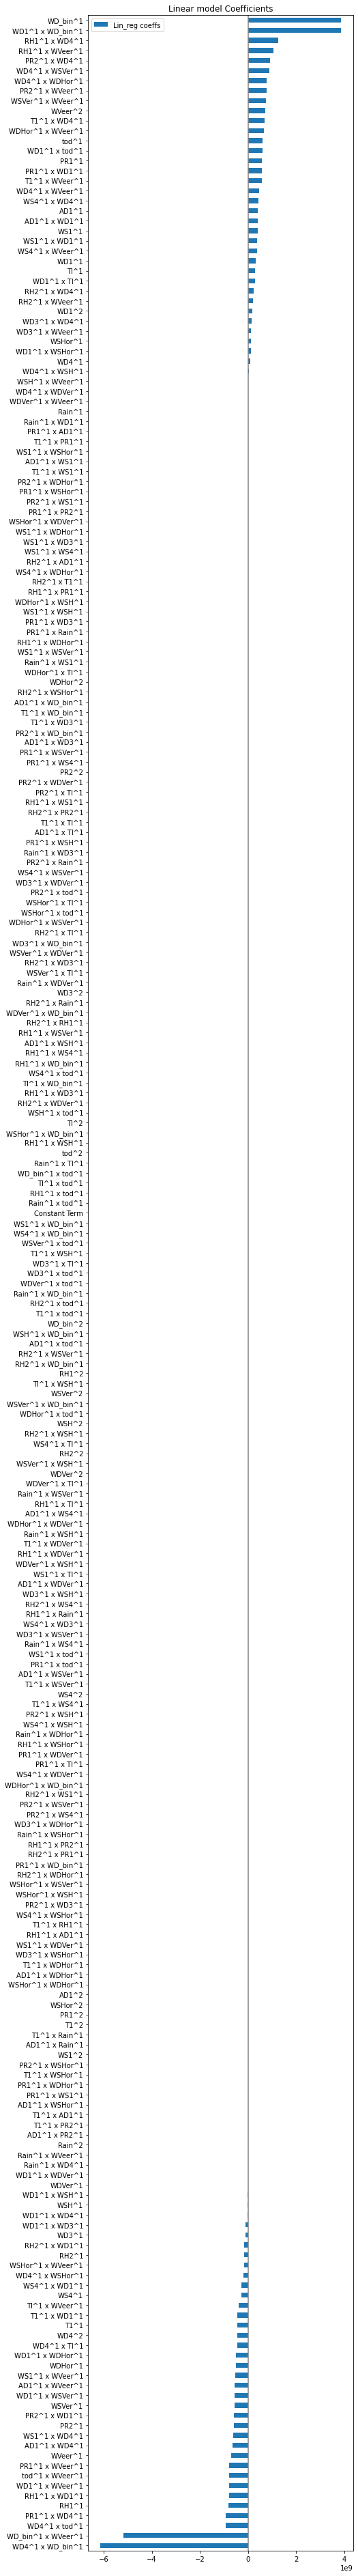

In [29]:
list_2drop=['T2', 'AD2', 'WS3']
X_train1, X_test1 =data_drop(X_train, X_test, list_2drop)
degree=2
cv=None
alphas=None
model='linear'
l1_ratios=None
polynomial_regression(degree, model, cv, alphas, l1_ratios, X_train1, X_test1, y_train, y_test, PC, plot=False)

### Ridge regression

In [30]:
# alphas=[0.5, 1, 10, 50, 80, 120, 300, 500]

Best alpha:  0.5

Of 24 coefficients, 24 are non-zero with RidgeCV.

power curve computation performed
power curve computation performed
Modelling errors for training set:
Wind RMSE:  0.425 m/s as root mean
Wind MAE:  0.32 m/s in avg
Wind MAPE:  3.739 %
Power RMSE:  186.691 kW as root mean
Power MAE:  116.232 kW in avg
Power MAPE:  8.391 %

Modelling errors for test set:
Wind RMSE:  0.435 m/s as root mean
Wind MAE:  0.328 m/s in avg
Wind MAPE:  3.839 %
Power RMSE:  195.004 kW as root mean
Power MAE:  124.177 kW in avg
Power MAPE:  8.684 %

Showing the results of the modelling: 

RidgeCV regression & results performed


RidgeCV(alphas=array([  0.5,   1. ,  10. ,  50. ,  80. , 120. , 300. , 500. ]),
        cv=4)

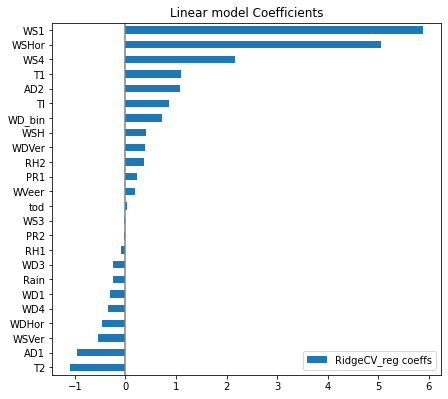

In [31]:
alphas=[0.5, 1, 10, 50, 80, 120, 300, 500]
cv=4
ridgecv_regression(X_train, X_test, y_train, y_test, cv, alphas, PC, plot=False)

Best alpha:  0.05

Of 24 coefficients, 24 are non-zero with RidgeCV.

power curve computation performed
power curve computation performed
Modelling errors for training set:
Wind RMSE:  0.421 m/s as root mean
Wind MAE:  0.318 m/s in avg
Wind MAPE:  3.717 %
Power RMSE:  187.186 kW as root mean
Power MAE:  116.4 kW in avg
Power MAPE:  8.361 %

Modelling errors for test set:
Wind RMSE:  0.435 m/s as root mean
Wind MAE:  0.328 m/s in avg
Wind MAPE:  3.839 %
Power RMSE:  196.43 kW as root mean
Power MAE:  124.95 kW in avg
Power MAPE:  8.678 %

Showing the results of the modelling: 

RidgeCV regression & results performed


RidgeCV(alphas=array([0.05, 0.1 , 0.2 , 0.3 , 0.4 , 0.5 , 0.6 , 0.7 , 0.8 , 0.9 , 1.  ]),
        cv=4)

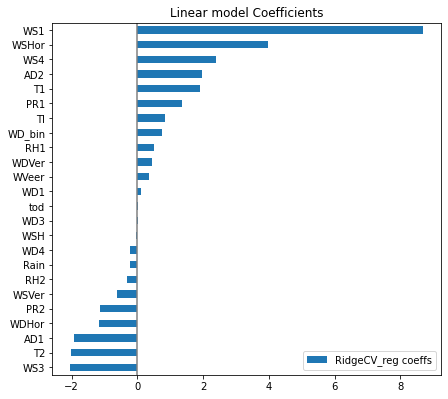

In [32]:
alphas=[0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
cv=4
ridgecv_regression(X_train, X_test, y_train, y_test, cv, alphas, PC, plot=False)

Best alpha:  0.005

Of 24 coefficients, 24 are non-zero with RidgeCV.

power curve computation performed
power curve computation performed
Modelling errors for training set:
Wind RMSE:  0.42 m/s as root mean
Wind MAE:  0.316 m/s in avg
Wind MAPE:  3.702 %
Power RMSE:  186.903 kW as root mean
Power MAE:  116.007 kW in avg
Power MAPE:  8.323 %

Modelling errors for test set:
Wind RMSE:  0.435 m/s as root mean
Wind MAE:  0.327 m/s in avg
Wind MAPE:  3.832 %
Power RMSE:  196.854 kW as root mean
Power MAE:  125.066 kW in avg
Power MAPE:  8.66 %

Showing the results of the modelling: 

RidgeCV regression & results performed


RidgeCV(alphas=array([0.005, 0.01 , 0.02 , 0.03 , 0.04 , 0.05 , 0.06 , 0.07 , 0.08 ,
       0.09 , 0.1  ]),
        cv=4)

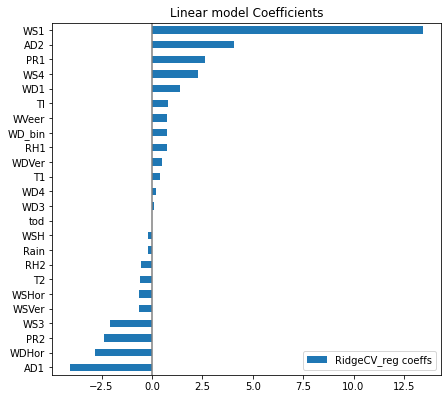

In [33]:
alphas=[0.005, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1]
cv=4
ridgecv_regression(X_train, X_test, y_train, y_test, cv, alphas, PC, plot=False)

### Polynomial Ridge regression

Best alpha:  0.001

Of 325 coefficients, 324 are non-zero with RidgeCV.

power curve computation performed
power curve computation performed
Modelling errors for training set:
Wind RMSE:  0.323 m/s as root mean
Wind MAE:  0.246 m/s in avg
Wind MAPE:  2.873 %
Power RMSE:  145.508 kW as root mean
Power MAE:  90.515 kW in avg
Power MAPE:  6.403 %

Modelling errors for test set:
Wind RMSE:  0.362 m/s as root mean
Wind MAE:  0.274 m/s in avg
Wind MAPE:  3.238 %
Power RMSE:  167.78 kW as root mean
Power MAE:  104.749 kW in avg
Power MAPE:  7.394 %

Showing the results of the modelling: 

RidgeCV regression & results performed

Polynomial regression & results performed


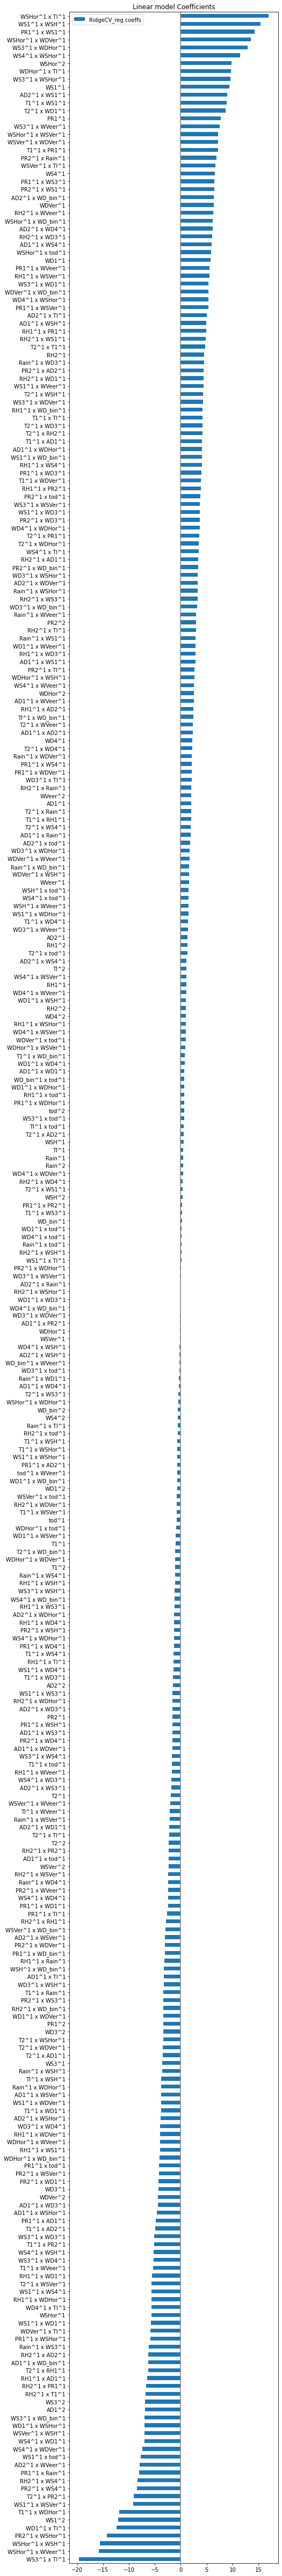

In [25]:
alphas=[0.0003, 0.0004, 0.0005, 0.001, 0.003, 0.005, 0.01, 0.03, 0.05, 0.1, 0.3, 0.5, 10, 50, 80, 120, 300, 500]
degree=2
model='ridge'
cv=4
l1_ratios=None



model, WS_pred=polynomial_regression(degree, model, cv, alphas, l1_ratios, X_train, X_test, y_train, y_test, PC,plot=False)

In [31]:
WS_pred=pd.DataFrame(WS_pred)

In [32]:
WS_pred

,WS_pred
0,9.128793
1,10.308399
2,11.073677
3,6.950827
4,10.338493
...,...
1301,11.476661
1302,13.084480
1303,5.901466
1304,7.780740


In [44]:
WS_pred=pd.DataFrame(WS_pred)
save(WS_pred,'\Results_','LR_WTG14.csv')

file LR_WTG14.csv saved in \Results_ folder


### Lasso regression

Best alpha:  0.05

Of 24 coefficients, 1 are non-zero with LassoCV.

power curve computation performed
power curve computation performed
Modelling errors for training set:
Wind RMSE:  0.51 m/s as root mean
Wind MAE:  0.387 m/s in avg
Wind MAPE:  4.546 %
Power RMSE:  205.441 kW as root mean
Power MAE:  134.281 kW in avg
Power MAPE:  10.757 %

Modelling errors for test set:
Wind RMSE:  0.521 m/s as root mean
Wind MAE:  0.396 m/s in avg
Wind MAPE:  4.69 %
Power RMSE:  220.139 kW as root mean
Power MAE:  145.606 kW in avg
Power MAPE:  11.35 %

Showing the results of the modelling: 

LassoCV regression & results performed


LassoCV(alphas=[0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7], cv=4)

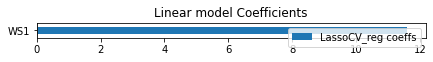

In [37]:
alphas=[0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]
cv=4
lassocv_regression(X_train, X_test, y_train, y_test, cv, alphas, PC, plot=False)

Best alpha:  0.005

Of 24 coefficients, 6 are non-zero with LassoCV.

power curve computation performed
power curve computation performed
Modelling errors for training set:
Wind RMSE:  0.438 m/s as root mean
Wind MAE:  0.325 m/s in avg
Wind MAPE:  3.763 %
Power RMSE:  191.573 kW as root mean
Power MAE:  117.285 kW in avg
Power MAPE:  8.316 %

Modelling errors for test set:
Wind RMSE:  0.449 m/s as root mean
Wind MAE:  0.335 m/s in avg
Wind MAPE:  3.897 %
Power RMSE:  202.352 kW as root mean
Power MAE:  127.523 kW in avg
Power MAPE:  8.769 %

Showing the results of the modelling: 

LassoCV regression & results performed


LassoCV(alphas=[0.005, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07], cv=4)

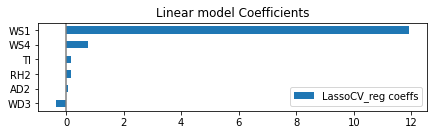

In [38]:
alphas=[0.005, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07]
cv=4
lassocv_regression(X_train, X_test, y_train, y_test, cv, alphas, PC, plot=False)

Best alpha:  0.0005

Of 24 coefficients, 16 are non-zero with LassoCV.

power curve computation performed
power curve computation performed
Modelling errors for training set:
Wind RMSE:  0.426 m/s as root mean
Wind MAE:  0.32 m/s in avg
Wind MAPE:  3.723 %
Power RMSE:  187.031 kW as root mean
Power MAE:  115.813 kW in avg
Power MAPE:  8.299 %

Modelling errors for test set:
Wind RMSE:  0.438 m/s as root mean
Wind MAE:  0.329 m/s in avg
Wind MAPE:  3.846 %
Power RMSE:  197.681 kW as root mean
Power MAE:  125.145 kW in avg
Power MAPE:  8.668 %

Showing the results of the modelling: 

LassoCV regression & results performed


LassoCV(alphas=[0.0005, 0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007], cv=4)

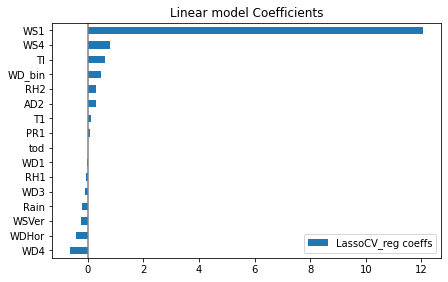

In [39]:
alphas=[0.0005, 0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007]
cv=4
lassocv_regression(X_train, X_test, y_train, y_test, cv, alphas, PC, plot=False)

Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.716167276005194, tolerance: 1.8574237477615292
Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.489875409555907, tolerance: 1.8318935024359766
Objective did not converge. You might want to increase the number of iterations. Duality gap: 12.431594669784658, tolerance: 1.8318935024359766


Best alpha:  0.0001

Of 24 coefficients, 19 are non-zero with LassoCV.

power curve computation performed
power curve computation performed
Modelling errors for training set:
Wind RMSE:  0.421 m/s as root mean
Wind MAE:  0.317 m/s in avg
Wind MAPE:  3.705 %
Power RMSE:  186.508 kW as root mean
Power MAE:  115.839 kW in avg
Power MAPE:  8.322 %

Modelling errors for test set:
Wind RMSE:  0.435 m/s as root mean
Wind MAE:  0.327 m/s in avg
Wind MAPE:  3.835 %
Power RMSE:  196.631 kW as root mean
Power MAE:  124.756 kW in avg
Power MAPE:  8.67 %

Showing the results of the modelling: 

LassoCV regression & results performed


LassoCV(alphas=[0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007], cv=4)

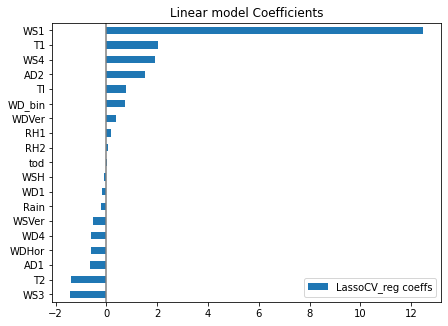

In [40]:
alphas=[0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007]
cv=4
lassocv_regression(X_train, X_test, y_train, y_test, cv, alphas, PC, plot=False)

I cannot set lower alphas because it does not converge

### Polynomial Lasso regression

Best alpha:  0.05

Of 325 coefficients, 1 are non-zero with LassoCV.

power curve computation performed
power curve computation performed
Modelling errors for training set:
Wind RMSE:  0.51 m/s as root mean
Wind MAE:  0.387 m/s in avg
Wind MAPE:  4.546 %
Power RMSE:  205.441 kW as root mean
Power MAE:  134.281 kW in avg
Power MAPE:  10.757 %

Modelling errors for test set:
Wind RMSE:  0.521 m/s as root mean
Wind MAE:  0.396 m/s in avg
Wind MAPE:  4.69 %
Power RMSE:  220.139 kW as root mean
Power MAE:  145.606 kW in avg
Power MAPE:  11.35 %

Showing the results of the modelling: 

LassoCV regression & results performed

Polynomial regression & results performed


LassoCV(alphas=[0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7], cv=4)

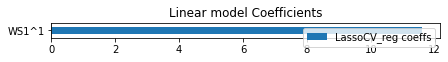

In [41]:
alphas=[0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]
degree=2
model='lasso'
cv=4
l1_ratios=None
polynomial_regression(degree, model, cv, alphas, l1_ratios, X_train, X_test, y_train, y_test, PC, plot=False)

Best alpha:  0.005

Of 325 coefficients, 13 are non-zero with LassoCV.

power curve computation performed
power curve computation performed
Modelling errors for training set:
Wind RMSE:  0.433 m/s as root mean
Wind MAE:  0.321 m/s in avg
Wind MAPE:  3.722 %
Power RMSE:  188.325 kW as root mean
Power MAE:  115.173 kW in avg
Power MAPE:  8.313 %

Modelling errors for test set:
Wind RMSE:  0.444 m/s as root mean
Wind MAE:  0.33 m/s in avg
Wind MAPE:  3.86 %
Power RMSE:  198.908 kW as root mean
Power MAE:  125.447 kW in avg
Power MAPE:  8.778 %

Showing the results of the modelling: 

LassoCV regression & results performed

Polynomial regression & results performed


LassoCV(alphas=[0.005, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07], cv=4)

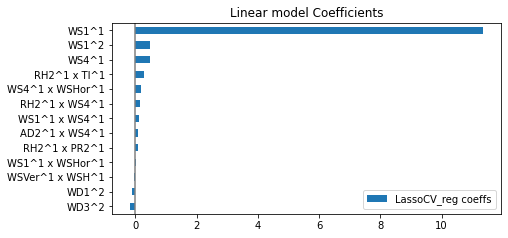

In [42]:
alphas=[0.005, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07]
degree=2
model='lasso'
cv=4
l1_ratios=None
polynomial_regression(degree, model, cv, alphas, l1_ratios, X_train, X_test, y_train, y_test, PC, plot=False)

Best alpha:  0.001

Of 325 coefficients, 32 are non-zero with LassoCV.

power curve computation performed
power curve computation performed
Modelling errors for training set:
Wind RMSE:  0.393 m/s as root mean
Wind MAE:  0.294 m/s in avg
Wind MAPE:  3.416 %
Power RMSE:  169.233 kW as root mean
Power MAE:  104.96 kW in avg
Power MAPE:  7.639 %

Modelling errors for test set:
Wind RMSE:  0.402 m/s as root mean
Wind MAE:  0.301 m/s in avg
Wind MAPE:  3.523 %
Power RMSE:  179.632 kW as root mean
Power MAE:  113.335 kW in avg
Power MAPE:  7.979 %

Showing the results of the modelling: 

LassoCV regression & results performed

Polynomial regression & results performed


LassoCV(alphas=[0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007], cv=4)

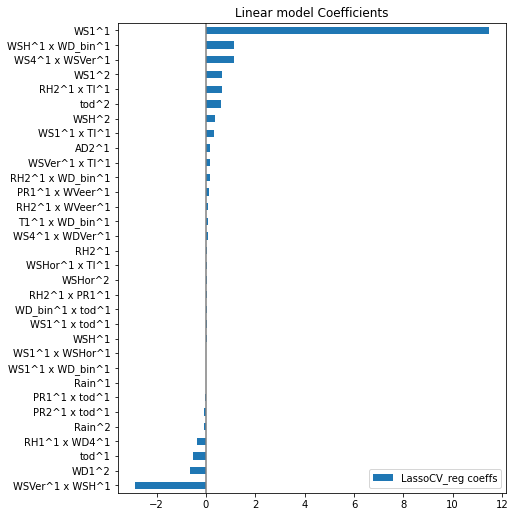

In [43]:
alphas=[0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007]
degree=2
model='lasso'
cv=4
l1_ratios=None
polynomial_regression(degree, model, cv, alphas, l1_ratios, X_train, X_test, y_train, y_test, PC, plot=False)

Best alpha:  0.0005

Of 325 coefficients, 45 are non-zero with LassoCV.

power curve computation performed
power curve computation performed
Modelling errors for training set:
Wind RMSE:  0.375 m/s as root mean
Wind MAE:  0.281 m/s in avg
Wind MAPE:  3.282 %
Power RMSE:  162.792 kW as root mean
Power MAE:  100.948 kW in avg
Power MAPE:  7.362 %

Modelling errors for test set:
Wind RMSE:  0.386 m/s as root mean
Wind MAE:  0.289 m/s in avg
Wind MAPE:  3.383 %
Power RMSE:  173.074 kW as root mean
Power MAE:  108.633 kW in avg
Power MAPE:  7.662 %

Showing the results of the modelling: 

LassoCV regression & results performed

Polynomial regression & results performed


LassoCV(alphas=[0.0005, 0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007], cv=4)

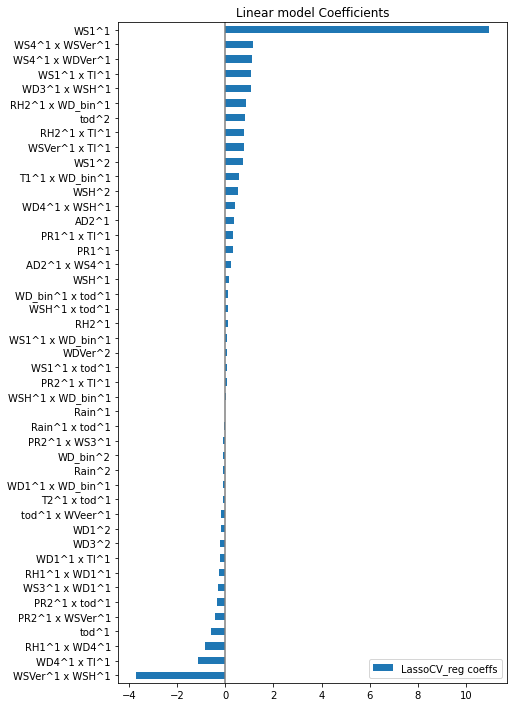

In [44]:
alphas=[0.0005, 0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007]
degree=2
model='lasso'
cv=4
l1_ratios=None
polynomial_regression(degree, model, cv, alphas, l1_ratios, X_train, X_test, y_train, y_test, PC, plot=False)

Best alpha:  0.0004

Of 325 coefficients, 46 are non-zero with LassoCV.

power curve computation performed
power curve computation performed
Modelling errors for training set:
Wind RMSE:  0.371 m/s as root mean
Wind MAE:  0.278 m/s in avg
Wind MAPE:  3.246 %
Power RMSE:  161.664 kW as root mean
Power MAE:  100.133 kW in avg
Power MAPE:  7.289 %

Modelling errors for test set:
Wind RMSE:  0.382 m/s as root mean
Wind MAE:  0.286 m/s in avg
Wind MAPE:  3.358 %
Power RMSE:  171.963 kW as root mean
Power MAE:  107.848 kW in avg
Power MAPE:  7.613 %

Showing the results of the modelling: 

LassoCV regression & results performed

Polynomial regression & results performed


LassoCV(alphas=[0.0004, 0.0005, 0.0006, 0.001, 0.002, 0.003, 0.004, 0.005],
        cv=4)

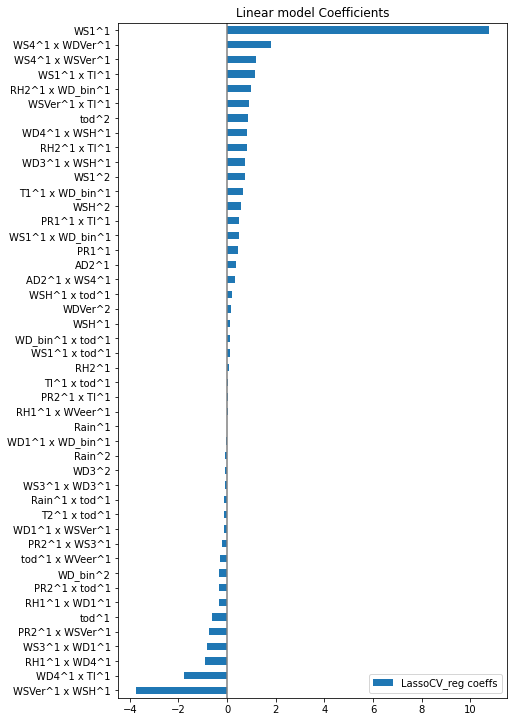

In [45]:
alphas=[0.0004, 0.0005, 0.0006, 0.001, 0.002, 0.003, 0.004, 0.005]
degree=2
model='lasso'
cv=4
l1_ratios=None
polynomial_regression(degree, model, cv, alphas, l1_ratios, X_train, X_test, y_train, y_test, PC, plot=False)

Best alpha:  0.0003

Of 325 coefficients, 56 are non-zero with LassoCV.

power curve computation performed
power curve computation performed
Modelling errors for training set:
Wind RMSE:  0.367 m/s as root mean
Wind MAE:  0.276 m/s in avg
Wind MAPE:  3.222 %
Power RMSE:  160.889 kW as root mean
Power MAE:  99.644 kW in avg
Power MAPE:  7.246 %

Modelling errors for test set:
Wind RMSE:  0.379 m/s as root mean
Wind MAE:  0.285 m/s in avg
Wind MAPE:  3.344 %
Power RMSE:  171.058 kW as root mean
Power MAE:  107.327 kW in avg
Power MAPE:  7.592 %

Showing the results of the modelling: 

LassoCV regression & results performed

Polynomial regression & results performed


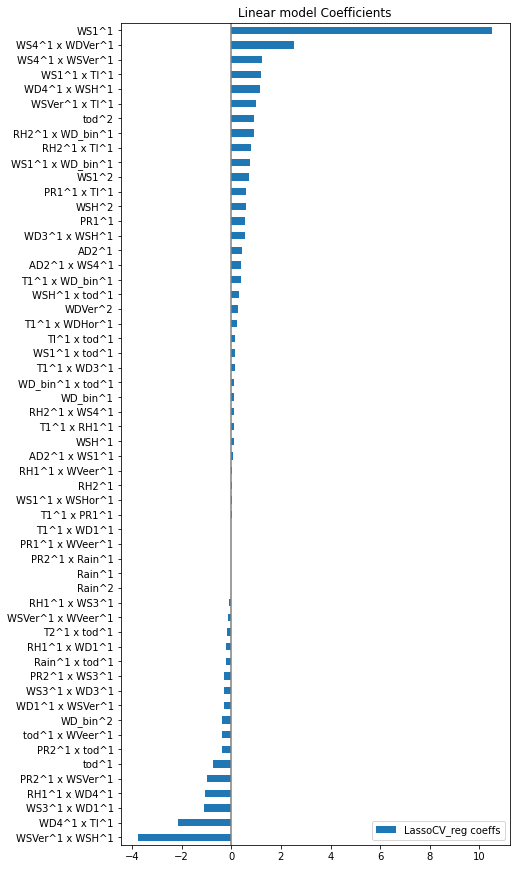

In [46]:
alphas=[0.0003, 0.0004, 0.0005, 0.0006]
degree=2
model='lasso'
cv=4
l1_ratios=None
model=polynomial_regression(degree, model, cv, alphas, l1_ratios, X_train, X_test, y_train, y_test, PC, plot=False)

## Feature importance

In [26]:
X_test_poly=PolynomialFeatures_labeled(X_test,2)

In [27]:
X_train_poly=PolynomialFeatures_labeled(X_train,2)

Permutation explainer: 1307it [1:10:34,  3.24s/it]                          


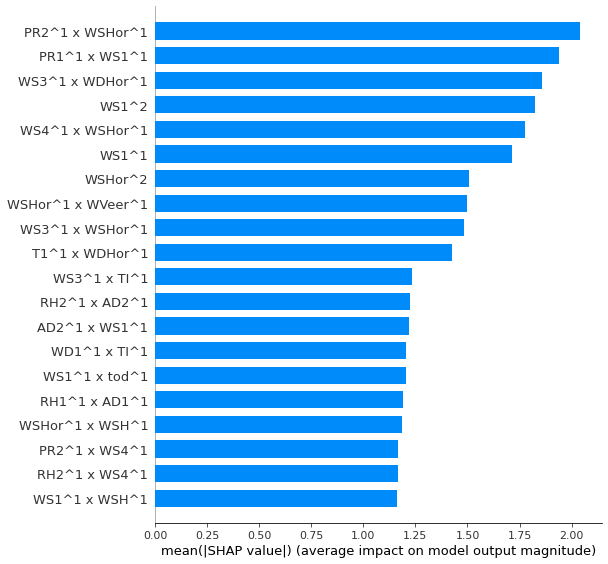

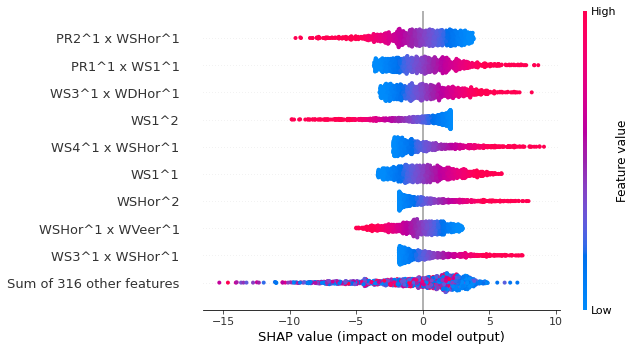

Feature importance through SHAP values performed


In [28]:
shap_values=feature_importance (X_train_poly, X_test_poly, model)

In [29]:
k=transform_shap (shap_values, X_test_poly)

In [30]:
save(k,'\Dataset1-Normal_Site','\SHAP_values_LR_WTG14.csv')

file \SHAP_values_LR_WTG14.csv saved in \Dataset1-Normal_Site folder


### ElasticNet regression

Best alpha:  0.005

Best l1_ratio:  0.9
Of 25 coefficients, 11 are non-zero with ElasticNetCV.

power curve computation performed
power curve computation performed
Modelling errors for training set:
Wind RMSE:  0.441 m/s as root mean
Wind MAE:  0.329 m/s in avg
Wind MAPE:  3.799 %
Power RMSE:  192.175 kW as root mean
Power MAE:  118.115 kW in avg
Power MAPE:  8.39 %

Modelling errors for test set:
Wind RMSE:  0.449 m/s as root mean
Wind MAE:  0.336 m/s in avg
Wind MAPE:  3.913 %
Power RMSE:  200.379 kW as root mean
Power MAE:  127.357 kW in avg
Power MAPE:  8.795 %

Showing the results of the modelling: 

ElasticNetCV regression & results performed


ElasticNetCV(alphas=array([5.0e-03, 5.0e-02, 1.0e-01, 1.0e+00, 5.0e+00, 2.0e+01, 5.0e+01,
       8.0e+01, 1.0e+02, 1.2e+02, 1.4e+02]),
             cv=4,
             l1_ratio=array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]),
             max_iter=10000.0)

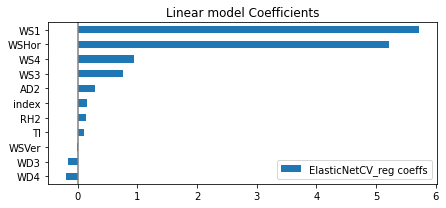

In [49]:
l1_ratios=np.linspace(0.1, 0.9, 9)
alphas=np.array([0.005, 0.05, 0.1, 1, 5, 20, 50, 80, 100, 120, 140])
cv=4
elasticnetcv_regression(X_train, X_test, y_train, y_test, cv, alphas, l1_ratios, PC, plot=False)

Best alpha:  0.05

Best l1_ratio:  0.9
Of 25 coefficients, 4 are non-zero with ElasticNetCV.

power curve computation performed
power curve computation performed
Modelling errors for training set:
Wind RMSE:  0.564 m/s as root mean
Wind MAE:  0.435 m/s in avg
Wind MAPE:  5.151 %
Power RMSE:  220.965 kW as root mean
Power MAE:  148.612 kW in avg
Power MAPE:  12.487 %

Modelling errors for test set:
Wind RMSE:  0.572 m/s as root mean
Wind MAE:  0.439 m/s in avg
Wind MAPE:  5.24 %
Power RMSE:  228.723 kW as root mean
Power MAE:  156.329 kW in avg
Power MAPE:  12.963 %

Showing the results of the modelling: 

ElasticNetCV regression & results performed


ElasticNetCV(alphas=[0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7], cv=4,
             l1_ratio=array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]),
             max_iter=10000.0)

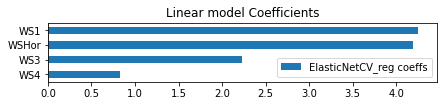

In [50]:
l1_ratios=np.linspace(0.1, 0.9, 9)
alphas=[0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]
cv=4
elasticnetcv_regression(X_train, X_test, y_train, y_test, cv, alphas, l1_ratios, PC, plot=False)

Best alpha:  0.005

Best l1_ratio:  0.9
Of 25 coefficients, 11 are non-zero with ElasticNetCV.

power curve computation performed
power curve computation performed
Modelling errors for training set:
Wind RMSE:  0.441 m/s as root mean
Wind MAE:  0.329 m/s in avg
Wind MAPE:  3.799 %
Power RMSE:  192.175 kW as root mean
Power MAE:  118.115 kW in avg
Power MAPE:  8.39 %

Modelling errors for test set:
Wind RMSE:  0.449 m/s as root mean
Wind MAE:  0.336 m/s in avg
Wind MAPE:  3.913 %
Power RMSE:  200.379 kW as root mean
Power MAE:  127.357 kW in avg
Power MAPE:  8.795 %

Showing the results of the modelling: 

ElasticNetCV regression & results performed


ElasticNetCV(alphas=[0.005, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07], cv=4,
             l1_ratio=array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]),
             max_iter=10000.0)

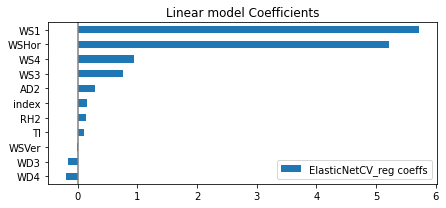

In [51]:
l1_ratios=np.linspace(0.1, 0.9, 9)
alphas=[0.005, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07]
cv=4
elasticnetcv_regression(X_train, X_test, y_train, y_test, cv, alphas, l1_ratios, PC, plot=False)

Best alpha:  0.001

Best l1_ratio:  0.9
Of 25 coefficients, 15 are non-zero with ElasticNetCV.

power curve computation performed
power curve computation performed
Modelling errors for training set:
Wind RMSE:  0.428 m/s as root mean
Wind MAE:  0.321 m/s in avg
Wind MAPE:  3.732 %
Power RMSE:  187.563 kW as root mean
Power MAE:  115.791 kW in avg
Power MAPE:  8.285 %

Modelling errors for test set:
Wind RMSE:  0.438 m/s as root mean
Wind MAE:  0.328 m/s in avg
Wind MAPE:  3.819 %
Power RMSE:  196.918 kW as root mean
Power MAE:  124.31 kW in avg
Power MAPE:  8.568 %

Showing the results of the modelling: 

ElasticNetCV regression & results performed


ElasticNetCV(alphas=[0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007], cv=4,
             l1_ratio=array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]),
             max_iter=10000.0)

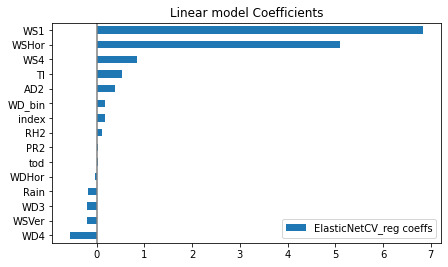

In [52]:
l1_ratios=np.linspace(0.1, 0.9, 9)
alphas=[0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007]
cv=4
elasticnetcv_regression(X_train, X_test, y_train, y_test, cv, alphas, l1_ratios, PC, plot=False)

### Polynomial ElasticNet regression

Best alpha:  0.005

Best l1_ratio:  0.1
Of 351 coefficients, 211 are non-zero with ElasticNetCV.

power curve computation performed
power curve computation performed
Modelling errors for training set:
Wind RMSE:  0.418 m/s as root mean
Wind MAE:  0.315 m/s in avg
Wind MAPE:  3.698 %
Power RMSE:  175.403 kW as root mean
Power MAE:  110.337 kW in avg
Power MAPE:  8.476 %

Modelling errors for test set:
Wind RMSE:  0.426 m/s as root mean
Wind MAE:  0.321 m/s in avg
Wind MAPE:  3.789 %
Power RMSE:  185.697 kW as root mean
Power MAE:  118.455 kW in avg
Power MAPE:  8.748 %

Showing the results of the modelling: 

ElasticNetCV regression & results performed

Polynomial regression & results performed


ElasticNetCV(alphas=array([5.0e-03, 5.0e-02, 1.0e-01, 1.0e+00, 5.0e+00, 2.0e+01, 5.0e+01,
       8.0e+01, 1.0e+02, 1.2e+02, 1.4e+02]),
             cv=4,
             l1_ratio=array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]),
             max_iter=10000.0)

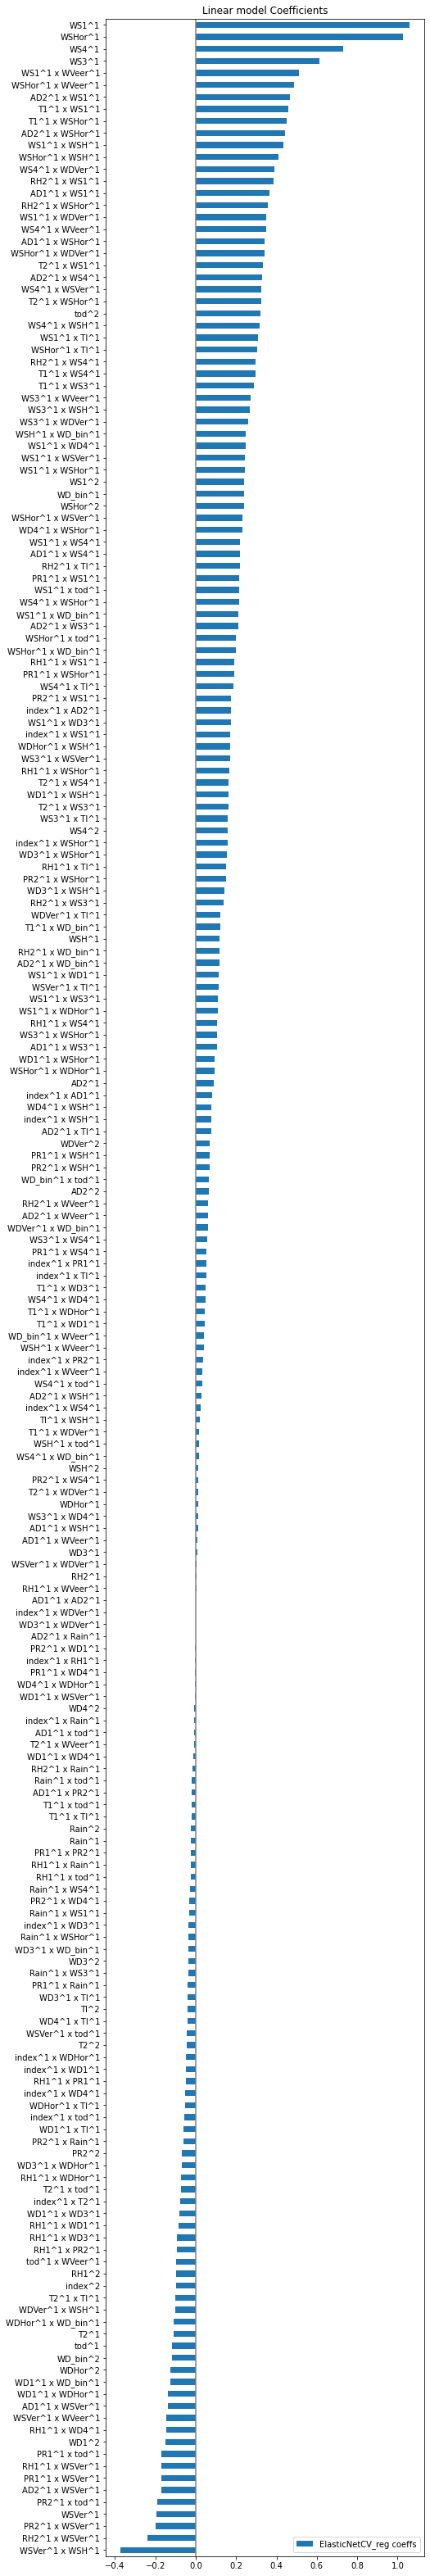

In [53]:
l1_ratios=np.linspace(0.1, 0.9, 9)
alphas=np.array([0.005, 0.05, 0.1, 1, 5, 20, 50, 80, 100, 120, 140])
degree=2
model='elasticnet'
cv=4



polynomial_regression(degree, model, cv, alphas, l1_ratios, X_train, X_test, y_train, y_test, PC, plot=False)

Best alpha:  0.005

Best l1_ratio:  0.9
Of 15 coefficients, 7 are non-zero with ElasticNetCV.

power curve computation performed
power curve computation performed
Modelling errors for training set:
Wind RMSE:  0.446 m/s as root mean
Wind MAE:  0.333 m/s in avg
Wind MAPE:  3.933 %
Power RMSE:  191.253 kW as root mean
Power MAE:  119.167 kW in avg
Power MAPE:  9.144 %

Modelling errors for test set:
Wind RMSE:  0.454 m/s as root mean
Wind MAE:  0.339 m/s in avg
Wind MAPE:  4.032 %
Power RMSE:  203.041 kW as root mean
Power MAE:  128.454 kW in avg
Power MAPE:  9.509 %

Showing the results of the modelling: 

ElasticNetCV regression & results performed

Polynomial regression & results performed


ElasticNetCV(alphas=array([5.0e-03, 5.0e-02, 1.0e-01, 1.0e+00, 5.0e+00, 2.0e+01, 5.0e+01,
       8.0e+01, 1.0e+02, 1.2e+02, 1.4e+02]),
             cv=4,
             l1_ratio=array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]),
             max_iter=10000.0)

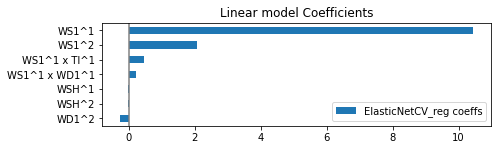

In [54]:
l1_ratios=np.linspace(0.1, 0.9, 9)
alphas=np.array([0.005, 0.05, 0.1, 1, 5, 20, 50, 80, 100, 120, 140])
degree=2
model='elasticnet'
cv=4

inputs=['WS1','WD1', 'WSH', 'TI']
X_train1, X_test1 =data_selection(X_train, X_test, inputs)


polynomial_regression(degree, model, cv, alphas, l1_ratios, X_train1, X_test1, y_train, y_test, PC, plot=False)

## Dataset1- WTG15

In [45]:
#upload the dataset with file_folder, file_name
X_train= uploading_csv('\Dataset1-Normal_Site','\X_train15.csv')
X_test= uploading_csv('\Dataset1-Normal_Site','\X_test15.csv')
y_train= uploading_csv('\Dataset1-Normal_Site','\y_train15.csv')
y_test= uploading_csv('\Dataset1-Normal_Site','\y_test15.csv')

X_test.keys()

Index(['T2', 'RH2', 'T1', 'RH1', 'PR1', 'AD1', 'PR2', 'AD2', 'Rain', 'WS1',
       'WS3', 'WS4', 'WD1', 'WD3', 'WD4', 'WSHor', 'WDHor', 'WSVer', 'WDVer',
       'TI', 'WSH', 'WD_bin', 'tod', 'WVeer'],
      dtype='object')

In [46]:
y_test.keys()

Index(['Target'], dtype='object')

In [47]:
PC= uploading_csv('\Dataset1-Normal_Site','\PC_1.15kgm-3.csv')

In [48]:
# X_train, X_test=data_drop(X_train, X_test, 'Ri')

In [49]:
X_test.keys()

Index(['T2', 'RH2', 'T1', 'RH1', 'PR1', 'AD1', 'PR2', 'AD2', 'Rain', 'WS1',
       'WS3', 'WS4', 'WD1', 'WD3', 'WD4', 'WSHor', 'WDHor', 'WSVer', 'WDVer',
       'TI', 'WSH', 'WD_bin', 'tod', 'WVeer'],
      dtype='object')

In [50]:
X_test.head()

,T2,RH2,T1,RH1,PR1,AD1,PR2,AD2,Rain,WS1,...,WD4,WSHor,WDHor,WSVer,WDVer,TI,WSH,WD_bin,tod,WVeer
0,0.831524,0.057205,0.774723,0.135851,0.640437,0.251889,0.620963,0.194458,0.0,0.043218,...,0.618474,0.053397,0.527254,0.597812,0.574662,0.645157,0.121654,0.571429,0.657343,0.441540
1,0.402216,0.643296,0.431112,0.639998,0.650657,0.566577,0.649564,0.574618,0.0,0.250303,...,0.444440,0.266188,0.438850,0.345844,0.344226,0.037133,0.268664,0.428571,0.902098,0.578137
2,0.663791,0.258316,0.597352,0.357120,0.593819,0.398016,0.583806,0.326848,0.0,0.293851,...,0.432120,0.304254,0.355165,0.343924,0.350983,0.332962,0.103648,0.285714,0.503497,0.507801
3,0.340102,0.672496,0.294282,0.778151,0.534560,0.665217,0.533175,0.600063,0.0,0.197332,...,0.861253,0.202664,0.836561,0.748992,0.693200,0.494577,0.272657,0.857143,0.356643,0.435968
4,0.950073,0.094900,0.914964,0.161600,0.481603,0.089682,0.458897,0.055857,0.0,0.032566,...,0.325091,0.038485,0.310839,0.295642,0.218924,0.353318,0.143521,0.285714,0.755245,0.598722


### Linear regression

power curve computation performed
power curve computation performed
Modelling errors for training set:
Wind RMSE:  0.585 m/s as root mean
Wind MAE:  0.446 m/s in avg
Wind MAPE:  5.464 %
Power RMSE:  271.904 kW as root mean
Power MAE:  175.166 kW in avg
Power MAPE:  13.433 %

Modelling errors for test set:
Wind RMSE:  0.593 m/s as root mean
Wind MAE:  0.451 m/s in avg
Wind MAPE:  5.556 %
Power RMSE:  279.771 kW as root mean
Power MAE:  180.16 kW in avg
Power MAPE:  13.801 %

Showing the results of the modelling: 
Linear regression & results performed


LinearRegression()

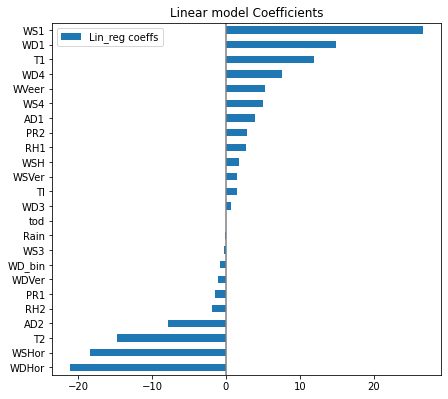

In [53]:
#results with all the variables
linear_regression(X_train, X_test, y_train, y_test, PC, plot=False)

power curve computation performed
power curve computation performed
Modelling errors for training set:
Wind RMSE:  0.594 m/s as root mean
Wind MAE:  0.454 m/s in avg
Wind MAPE:  5.557 %
Power RMSE:  275.783 kW as root mean
Power MAE:  178.229 kW in avg
Power MAPE:  13.661 %

Modelling errors for test set:
Wind RMSE:  0.6 m/s as root mean
Wind MAE:  0.454 m/s in avg
Wind MAPE:  5.605 %
Power RMSE:  284.267 kW as root mean
Power MAE:  182.437 kW in avg
Power MAPE:  14.014 %

Showing the results of the modelling: 
Linear regression & results performed


LinearRegression()

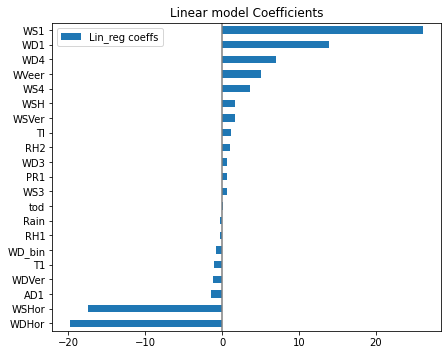

In [54]:
#dropping the following variables:
list_2drop=['T2', 'AD2', 'PR2']
X_train1, X_test1 =data_drop(X_train, X_test, list_2drop)
linear_regression(X_train1, X_test1, y_train, y_test, PC, plot=False)

power curve computation performed
power curve computation performed
Modelling errors for training set:
Wind RMSE:  0.6 m/s as root mean
Wind MAE:  0.458 m/s in avg
Wind MAPE:  5.613 %
Power RMSE:  276.794 kW as root mean
Power MAE:  179.225 kW in avg
Power MAPE:  13.825 %

Modelling errors for test set:
Wind RMSE:  0.608 m/s as root mean
Wind MAE:  0.463 m/s in avg
Wind MAPE:  5.733 %
Power RMSE:  286.714 kW as root mean
Power MAE:  184.814 kW in avg
Power MAPE:  14.418 %

Showing the results of the modelling: 
Linear regression & results performed


LinearRegression()

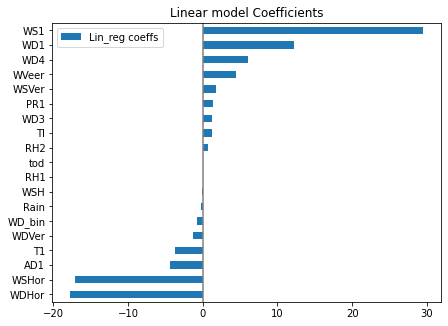

In [55]:
#dropping the following variables:
list_2drop=['T2', 'AD2', 'PR2', 'WS4', 'WS3']
X_train1, X_test1 =data_drop(X_train, X_test, list_2drop)
linear_regression(X_train1, X_test1, y_train, y_test, PC, plot=False)

power curve computation performed
power curve computation performed
Modelling errors for training set:
Wind RMSE:  0.628 m/s as root mean
Wind MAE:  0.475 m/s in avg
Wind MAPE:  5.794 %
Power RMSE:  283.578 kW as root mean
Power MAE:  183.087 kW in avg
Power MAPE:  14.287 %

Modelling errors for test set:
Wind RMSE:  0.632 m/s as root mean
Wind MAE:  0.477 m/s in avg
Wind MAPE:  5.888 %
Power RMSE:  294.238 kW as root mean
Power MAE:  188.9 kW in avg
Power MAPE:  14.919 %

Showing the results of the modelling: 
Linear regression & results performed


LinearRegression()

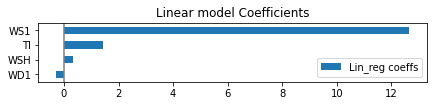

In [56]:
#SELECTING the following variables:
inputs=['WS1','WD1', 'WSH', 'TI']
X_train1, X_test1 =data_selection(X_train, X_test, inputs)
linear_regression(X_train1, X_test1, y_train, y_test, PC, plot=False)

### Polynomial Linear regression

power curve computation performed
power curve computation performed
Modelling errors for training set:
Wind RMSE:  0.489 m/s as root mean
Wind MAE:  0.375 m/s in avg
Wind MAPE:  4.643 %
Power RMSE:  227.079 kW as root mean
Power MAE:  147.453 kW in avg
Power MAPE:  11.427 %

Modelling errors for test set:
Wind RMSE:  0.528 m/s as root mean
Wind MAE:  0.402 m/s in avg
Wind MAPE:  4.967 %
Power RMSE:  247.204 kW as root mean
Power MAE:  158.519 kW in avg
Power MAPE:  12.354 %

Showing the results of the modelling: 
Linear regression & results performed

Polynomial regression & results performed


LinearRegression()

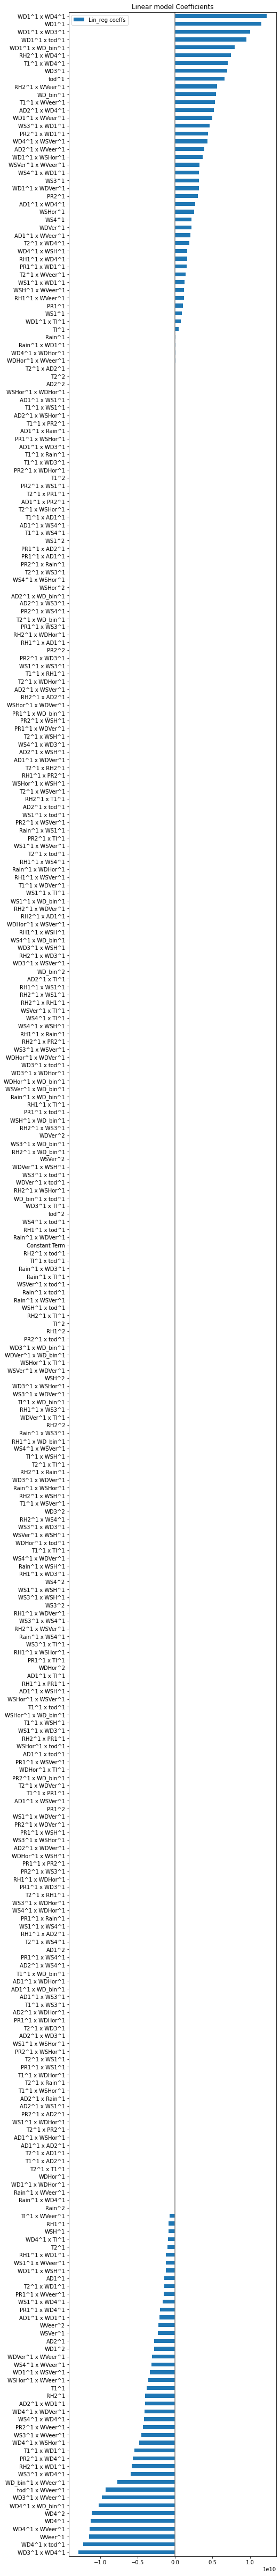

In [57]:
degree=2
cv=None
alphas=None
model='linear'
l1_ratios=None
polynomial_regression(degree, model, cv, alphas, l1_ratios, X_train, X_test, y_train, y_test, PC, plot=False)

power curve computation performed
power curve computation performed
Modelling errors for training set:
Wind RMSE:  0.598 m/s as root mean
Wind MAE:  0.453 m/s in avg
Wind MAPE:  5.524 %
Power RMSE:  278.431 kW as root mean
Power MAE:  177.465 kW in avg
Power MAPE:  13.437 %

Modelling errors for test set:
Wind RMSE:  0.604 m/s as root mean
Wind MAE:  0.454 m/s in avg
Wind MAPE:  5.571 %
Power RMSE:  287.617 kW as root mean
Power MAE:  181.981 kW in avg
Power MAPE:  13.898 %

Showing the results of the modelling: 
Linear regression & results performed

Polynomial regression & results performed


LinearRegression()

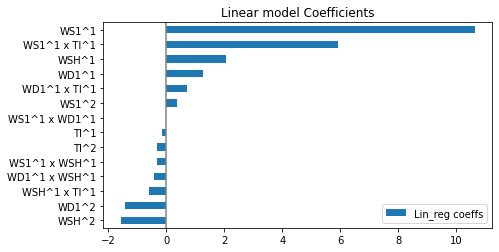

In [58]:
inputs=['WS1','WD1', 'WSH', 'TI']
X_train1, X_test1 =data_selection(X_train, X_test, inputs)
degree=2
cv=None
alphas=None
l1_ratio=None
model='linear'
polynomial_regression(degree, model, cv, alphas, l1_ratio, X_train1, X_test1, y_train, y_test, PC, plot=False)

power curve computation performed
power curve computation performed
Modelling errors for training set:
Wind RMSE:  0.576 m/s as root mean
Wind MAE:  0.438 m/s in avg
Wind MAPE:  5.326 %
Power RMSE:  264.003 kW as root mean
Power MAE:  169.096 kW in avg
Power MAPE:  12.887 %

Modelling errors for test set:
Wind RMSE:  0.576 m/s as root mean
Wind MAE:  0.433 m/s in avg
Wind MAPE:  5.302 %
Power RMSE:  266.588 kW as root mean
Power MAE:  170.402 kW in avg
Power MAPE:  13.069 %

Showing the results of the modelling: 
Linear regression & results performed

Polynomial regression & results performed


LinearRegression()

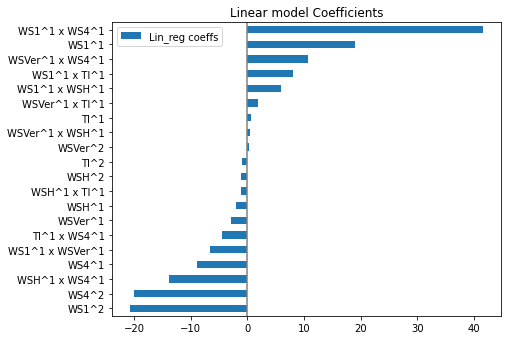

In [59]:
inputs=['WS1','WSVer', 'WSH', 'TI', 'WS4']
X_train1, X_test1 =data_selection(X_train, X_test, inputs)
degree=2
cv=None
alphas=None
l1_ratio=None
model='linear'
polynomial_regression(degree, model, cv, alphas, l1_ratio, X_train1, X_test1, y_train, y_test, PC, plot=False)

power curve computation performed
power curve computation performed
Modelling errors for training set:
Wind RMSE:  0.55 m/s as root mean
Wind MAE:  0.42 m/s in avg
Wind MAPE:  5.156 %
Power RMSE:  255.713 kW as root mean
Power MAE:  164.134 kW in avg
Power MAPE:  12.605 %

Modelling errors for test set:
Wind RMSE:  0.555 m/s as root mean
Wind MAE:  0.42 m/s in avg
Wind MAPE:  5.154 %
Power RMSE:  259.467 kW as root mean
Power MAE:  165.632 kW in avg
Power MAPE:  12.755 %

Showing the results of the modelling: 
Linear regression & results performed

Polynomial regression & results performed


LinearRegression()

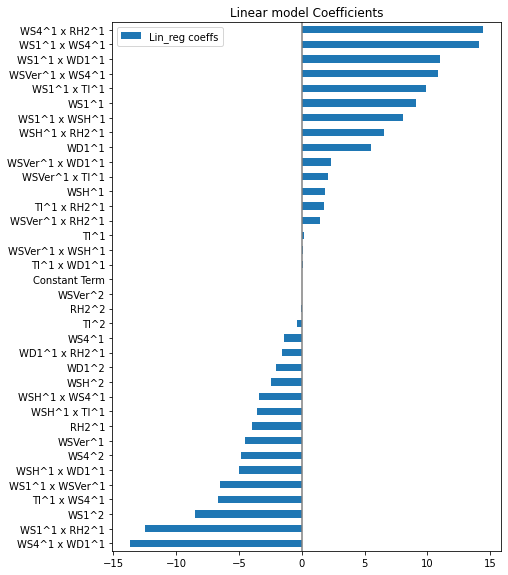

In [60]:
inputs=['WS1','WSVer', 'WSH', 'TI', 'WS4', 'WD1', 'RH2']
X_train1, X_test1 =data_selection(X_train, X_test, inputs)
degree=2
cv=None
alphas=None
l1_ratio=None
model='linear'
polynomial_regression(degree, model, cv, alphas, l1_ratio, X_train1, X_test1, y_train, y_test, PC, plot=False)

### Ridge regression

In [61]:
# alphas=[0.5, 1, 10, 50, 80, 120, 300, 500]

Best alpha:  0.001

Of 24 coefficients, 24 are non-zero with RidgeCV.

power curve computation performed
power curve computation performed
Modelling errors for training set:
Wind RMSE:  0.585 m/s as root mean
Wind MAE:  0.446 m/s in avg
Wind MAPE:  5.464 %
Power RMSE:  271.892 kW as root mean
Power MAE:  175.172 kW in avg
Power MAPE:  13.43 %

Modelling errors for test set:
Wind RMSE:  0.593 m/s as root mean
Wind MAE:  0.451 m/s in avg
Wind MAPE:  5.554 %
Power RMSE:  279.745 kW as root mean
Power MAE:  180.083 kW in avg
Power MAPE:  13.793 %

Showing the results of the modelling: 

RidgeCV regression & results performed


RidgeCV(alphas=array([3.0e-04, 4.0e-04, 5.0e-04, 1.0e-03, 3.0e-03, 5.0e-03, 1.0e-02,
       3.0e-02, 5.0e-02, 1.0e-01, 3.0e-01, 5.0e-01, 1.0e+01, 5.0e+01,
       8.0e+01, 1.2e+02, 3.0e+02, 5.0e+02]),
        cv=4)

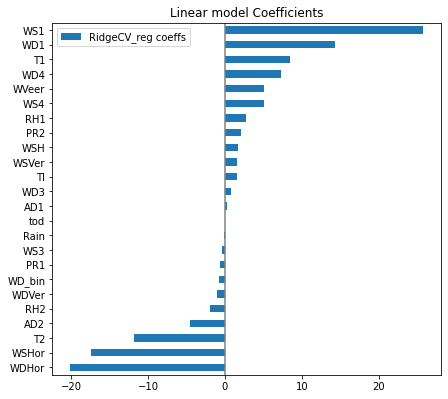

In [62]:
alphas=[0.0003, 0.0004, 0.0005, 0.001, 0.003, 0.005, 0.01, 0.03, 0.05, 0.1, 0.3, 0.5, 10, 50, 80, 120, 300, 500]
cv=4
ridgecv_regression(X_train, X_test, y_train, y_test, cv, alphas, PC, plot=False)

### Polynomial Ridge regression

Best alpha:  0.001

Of 325 coefficients, 324 are non-zero with RidgeCV.

power curve computation performed
power curve computation performed
Modelling errors for training set:
Wind RMSE:  0.498 m/s as root mean
Wind MAE:  0.382 m/s in avg
Wind MAPE:  4.731 %
Power RMSE:  231.421 kW as root mean
Power MAE:  150.488 kW in avg
Power MAPE:  11.65 %

Modelling errors for test set:
Wind RMSE:  0.527 m/s as root mean
Wind MAE:  0.404 m/s in avg
Wind MAPE:  4.996 %
Power RMSE:  249.611 kW as root mean
Power MAE:  160.081 kW in avg
Power MAPE:  12.463 %

Showing the results of the modelling: 

RidgeCV regression & results performed

Polynomial regression & results performed


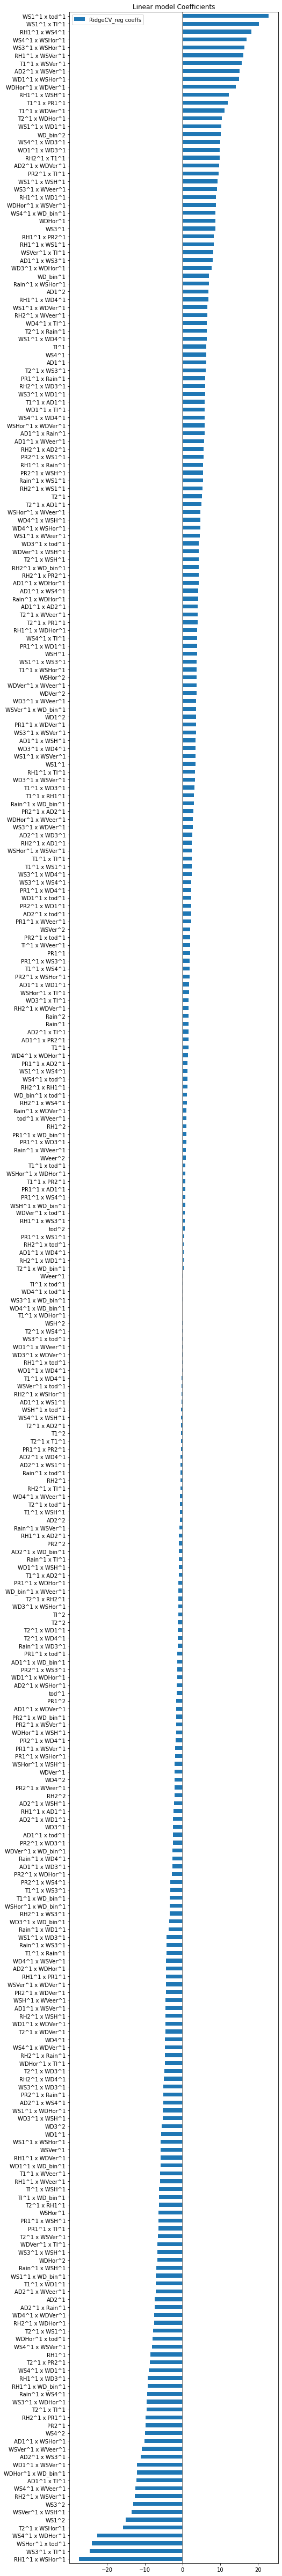

In [51]:
alphas=[0.0003, 0.0004, 0.0005, 0.001, 0.003, 0.005, 0.01, 0.03, 0.05, 0.1, 0.3, 0.5, 10, 50, 80, 120, 300, 500]
degree=2
model='ridge'
cv=4
l1_ratios=None


model, WS_pred=polynomial_regression(degree, model, cv, alphas, l1_ratios, X_train, X_test, y_train, y_test, PC, plot=False)

In [52]:
WS_pred=pd.DataFrame(WS_pred)
save(WS_pred,'\Results_','LR_WTG15.csv')

file LR_WTG15.csv saved in \Results_ folder


### Lasso regression

Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.087241664539306, tolerance: 2.5135330294385096
Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.217646393891073, tolerance: 2.5135330294385096
Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.4465368759656485, tolerance: 2.476338945432923
Objective did not converge. You might want to increase the number of iterations. Duality gap: 24.411844054489166, tolerance: 3.3041638784842937


Best alpha:  0.0003

Of 24 coefficients, 18 are non-zero with LassoCV.

power curve computation performed
power curve computation performed
Modelling errors for training set:
Wind RMSE:  0.595 m/s as root mean
Wind MAE:  0.453 m/s in avg
Wind MAPE:  5.544 %
Power RMSE:  276.093 kW as root mean
Power MAE:  177.696 kW in avg
Power MAPE:  13.621 %

Modelling errors for test set:
Wind RMSE:  0.6 m/s as root mean
Wind MAE:  0.455 m/s in avg
Wind MAPE:  5.59 %
Power RMSE:  282.878 kW as root mean
Power MAE:  182.027 kW in avg
Power MAPE:  13.885 %

Showing the results of the modelling: 

LassoCV regression & results performed


LassoCV(alphas=[0.0003, 0.0004, 0.0005, 0.001, 0.003, 0.005, 0.01, 0.03, 0.05,
                0.1, 0.3, 0.5, 10, 50, 80, 120, 300, 500],
        cv=4)

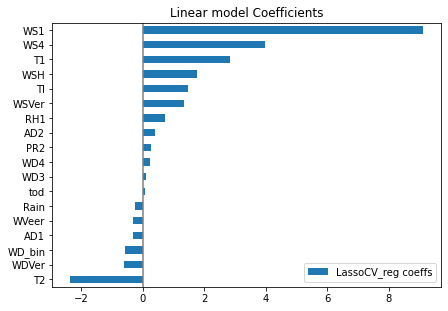

In [64]:
alphas=[0.0003, 0.0004, 0.0005, 0.001, 0.003, 0.005, 0.01, 0.03, 0.05, 0.1, 0.3, 0.5, 10, 50, 80, 120, 300, 500]
cv=4
lassocv_regression(X_train, X_test, y_train, y_test, cv, alphas, PC, plot=False)

### Polynomial Lasso regression

Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.51582022439834, tolerance: 2.46589185702679
Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.100488939629713, tolerance: 2.4559800146706405
Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.5502003489616527, tolerance: 2.476338945432923
Objective did not converge. You might want to increase the number of iterations. Duality gap: 10.80110001549997, tolerance: 3.3041638784842937


Best alpha:  0.0003

Of 325 coefficients, 57 are non-zero with LassoCV.

power curve computation performed
power curve computation performed
Modelling errors for training set:
Wind RMSE:  0.543 m/s as root mean
Wind MAE:  0.417 m/s in avg
Wind MAPE:  5.112 %
Power RMSE:  252.878 kW as root mean
Power MAE:  163.33 kW in avg
Power MAPE:  12.438 %

Modelling errors for test set:
Wind RMSE:  0.55 m/s as root mean
Wind MAE:  0.419 m/s in avg
Wind MAPE:  5.143 %
Power RMSE:  259.131 kW as root mean
Power MAE:  166.155 kW in avg
Power MAPE:  12.669 %

Showing the results of the modelling: 

LassoCV regression & results performed

Polynomial regression & results performed


LassoCV(alphas=[0.0003, 0.0004, 0.0005, 0.001, 0.003, 0.005, 0.01, 0.03, 0.05,
                0.1, 0.3, 0.5, 10, 50, 80, 120, 300, 500],
        cv=4)

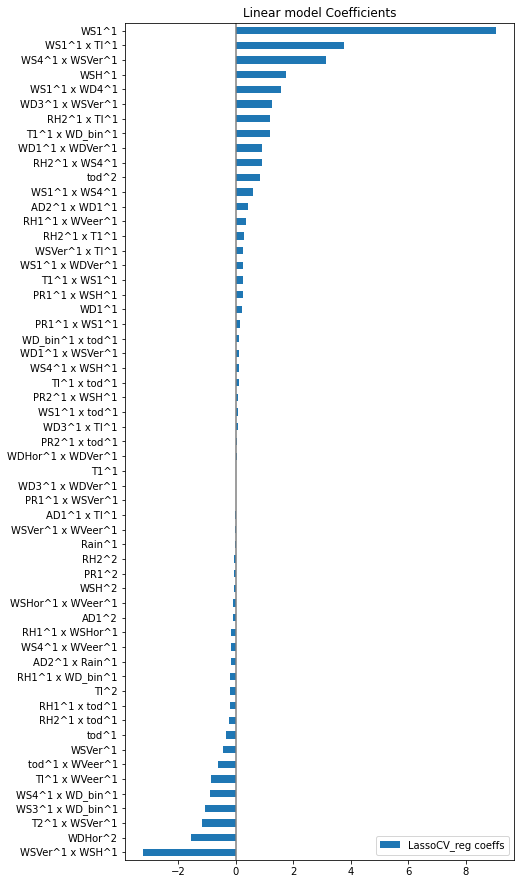

In [65]:
alphas=[0.0003, 0.0004, 0.0005, 0.001, 0.003, 0.005, 0.01, 0.03, 0.05, 0.1, 0.3, 0.5, 10, 50, 80, 120, 300, 500]
degree=2
model='lasso'
cv=4
l1_ratios=None
polynomial_regression(degree, model, cv,  alphas, l1_ratios, X_train, X_test, y_train, y_test, PC, plot=False)

Best alpha:  0.0005

Of 325 coefficients, 40 are non-zero with LassoCV.

power curve computation performed
power curve computation performed
Modelling errors for training set:
Wind RMSE:  0.549 m/s as root mean
Wind MAE:  0.421 m/s in avg
Wind MAPE:  5.144 %
Power RMSE:  255.672 kW as root mean
Power MAE:  164.619 kW in avg
Power MAPE:  12.504 %

Modelling errors for test set:
Wind RMSE:  0.555 m/s as root mean
Wind MAE:  0.421 m/s in avg
Wind MAPE:  5.156 %
Power RMSE:  261.44 kW as root mean
Power MAE:  167.226 kW in avg
Power MAPE:  12.662 %

Showing the results of the modelling: 

LassoCV regression & results performed

Polynomial regression & results performed


LassoCV(alphas=[0.0005, 0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008,
                0.009, 0.01],
        cv=4)

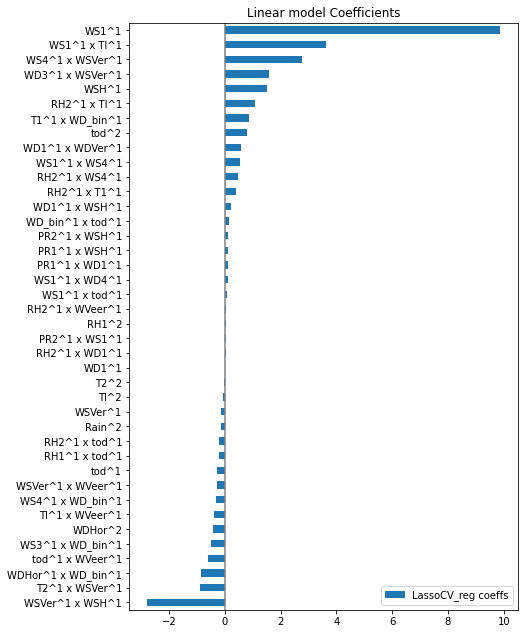

In [66]:
alphas=[0.0005, 0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008, 0.009, 0.01]
degree=2
model='lasso'
cv=4
l1_ratios=None
polynomial_regression(degree, model, cv, alphas, l1_ratios, X_train, X_test, y_train, y_test, PC, plot=False)

### ElasticNet regression

Best alpha:  0.001

Best l1_ratio:  0.9
Of 24 coefficients, 14 are non-zero with ElasticNetCV.

power curve computation performed
power curve computation performed
Modelling errors for training set:
Wind RMSE:  0.604 m/s as root mean
Wind MAE:  0.459 m/s in avg
Wind MAPE:  5.608 %
Power RMSE:  277.923 kW as root mean
Power MAE:  179.167 kW in avg
Power MAPE:  13.771 %

Modelling errors for test set:
Wind RMSE:  0.605 m/s as root mean
Wind MAE:  0.456 m/s in avg
Wind MAPE:  5.596 %
Power RMSE:  283.786 kW as root mean
Power MAE:  182.019 kW in avg
Power MAPE:  13.892 %

Showing the results of the modelling: 

ElasticNetCV regression & results performed


ElasticNetCV(alphas=[0.001, 0.002, 0.003, 0.004, 0.008, 0.01, 0.012], cv=4,
             l1_ratio=array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]),
             max_iter=10000.0)

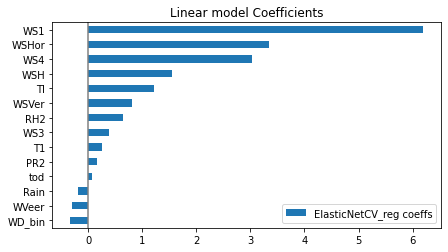

In [67]:
l1_ratios=np.linspace(0.1, 0.9, 9)
alphas=[0.001, 0.002, 0.003, 0.004, 0.008, 0.01, 0.012]
cv=4
elasticnetcv_regression(X_train, X_test, y_train, y_test, cv, alphas, l1_ratios, PC, plot=False)

Best alpha:  0.0005

Best l1_ratio:  0.9
Of 24 coefficients, 19 are non-zero with ElasticNetCV.

power curve computation performed
power curve computation performed
Modelling errors for training set:
Wind RMSE:  0.599 m/s as root mean
Wind MAE:  0.456 m/s in avg
Wind MAPE:  5.574 %
Power RMSE:  277.186 kW as root mean
Power MAE:  178.503 kW in avg
Power MAPE:  13.693 %

Modelling errors for test set:
Wind RMSE:  0.602 m/s as root mean
Wind MAE:  0.455 m/s in avg
Wind MAPE:  5.59 %
Power RMSE:  283.616 kW as root mean
Power MAE:  182.101 kW in avg
Power MAPE:  13.885 %

Showing the results of the modelling: 

ElasticNetCV regression & results performed


ElasticNetCV(alphas=[0.0005, 0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007],
             cv=4,
             l1_ratio=array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]),
             max_iter=10000.0)

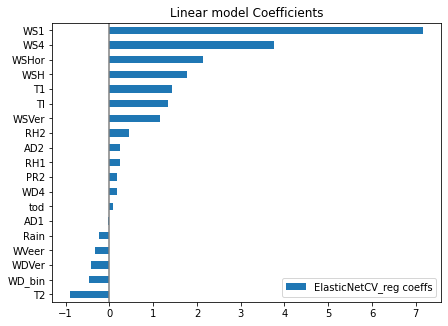

In [68]:
l1_ratios=np.linspace(0.1, 0.9, 9)
alphas=[0.0005, 0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007]
cv=4
elasticnetcv_regression(X_train, X_test, y_train, y_test, cv, alphas, l1_ratios, PC, plot=False)

### Polynomial ElasticNet regression

Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.693126123419688, tolerance: 3.3041638784842937


Best alpha:  0.0005

Best l1_ratio:  0.1
Of 325 coefficients, 256 are non-zero with ElasticNetCV.

power curve computation performed
power curve computation performed
Modelling errors for training set:
Wind RMSE:  0.543 m/s as root mean
Wind MAE:  0.417 m/s in avg
Wind MAPE:  5.111 %
Power RMSE:  252.412 kW as root mean
Power MAE:  163.091 kW in avg
Power MAPE:  12.477 %

Modelling errors for test set:
Wind RMSE:  0.551 m/s as root mean
Wind MAE:  0.42 m/s in avg
Wind MAPE:  5.177 %
Power RMSE:  258.653 kW as root mean
Power MAE:  166.463 kW in avg
Power MAPE:  12.819 %

Showing the results of the modelling: 

ElasticNetCV regression & results performed

Polynomial regression & results performed


ElasticNetCV(alphas=[0.0005, 0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007],
             cv=4,
             l1_ratio=array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]),
             max_iter=10000.0)

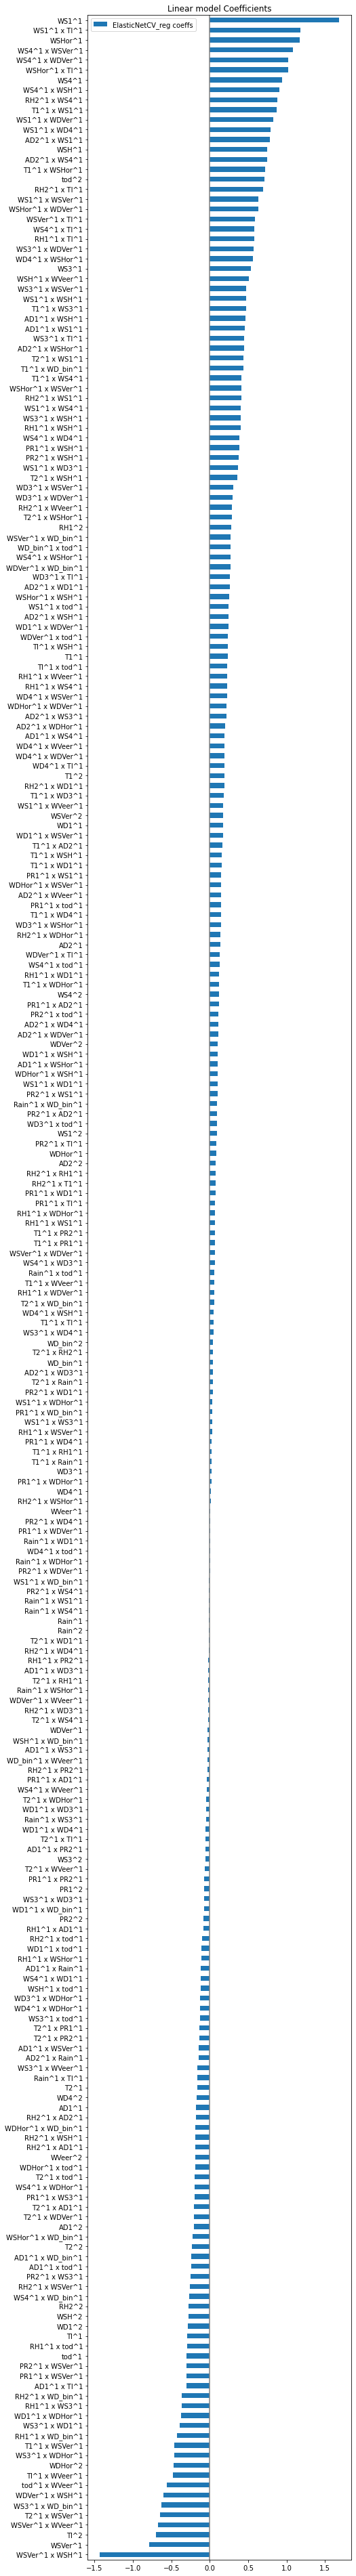

In [69]:
l1_ratios=np.linspace(0.1, 0.9, 9)
alphas=[0.0005, 0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007]
degree=2
model='elasticnet'
cv=4


polynomial_regression(degree, model, cv, alphas, l1_ratios, X_train, X_test, y_train, y_test, PC, plot=False)

### Feature Importance

In [45]:
X_test_poly=PolynomialFeatures_labeled(X_test,2)

In [46]:
X_train_poly=PolynomialFeatures_labeled(X_train,2)

Permutation explainer: 1881it [1:48:00,  3.45s/it]                            


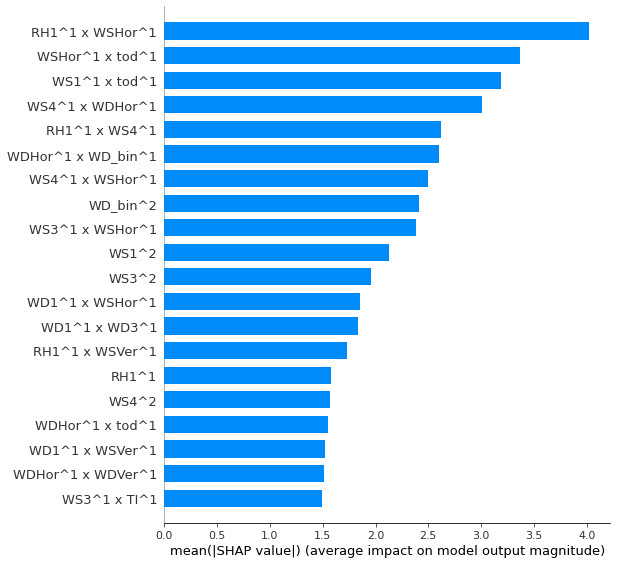

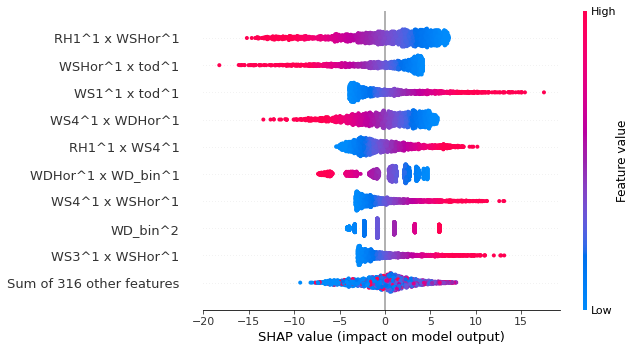

Feature importance through SHAP values performed


In [50]:
shap_values=feature_importance (X_train_poly, X_test_poly, model)

In [51]:
k=transform_shap (shap_values, X_test_poly)

In [52]:
save(k,'\Dataset1-Normal_Site','\SHAP_WTG15_LR.csv')

file \SHAP_WTG15_LR.csv saved in \Dataset1-Normal_Site folder
